<a id='introduction'></a>
# Step 1: Introduction and Core Physics

This notebook is a self-contained tutorial that uses the `nrpy` library to construct a complete C-language project for integrating photon geodesics in curved spacetimes. The resulting C code is a flexible, high-performance ray-tracing engine capable of generating gravitationally lensed images of distant sources as seen by an observer near a black hole.

The core of the project is the numerical solution of the geodesic equation, which describes the path of a free-falling particle (or photon) through curved spacetime. The geodesic equation, as detailed on [Wikipedia](https://en.wikipedia.org/wiki/Geodesic_equation), is a second-order ordinary differential equation (ODE) that relates a particle's acceleration to the spacetime curvature, represented by the Christoffel symbols ($\Gamma^{\alpha}_{\mu\nu}$):

$$ \frac{d^2x^{\alpha}}{d\lambda^2} = -\Gamma^{\alpha}_{\mu\nu} \frac{dx^{\mu}}{d\lambda} \frac{dx^{\nu}}{d\lambda} $$

Here, $x^\alpha = (t, x, y, z)$ are the spacetime coordinates, and $\lambda$ is the affine parameter, which measures the proper distance along the path for a massive particle or a suitable path parameter for a photon.

### The Reverse Ray-Tracing Transformation

To render an image of what an observer sees, we must trace the photon's path from the observer's camera *backwards in time* to its source. While we could integrate the geodesic equation with a negative step `dλ < 0`, most ODE solvers are optimized for forward integration with a positive step. To accommodate this, we perform a change of variables on the affine parameter. We define a new parameter, $\kappa$, that increases as the original parameter, $\lambda$, decreases:

$$ \kappa = -\lambda \implies d\kappa = -d\lambda \implies \frac{d}{d\lambda} = -\frac{d}{d\kappa} $$

We now substitute this transformation directly into the second-order geodesic equation:

$$ \frac{d}{d\lambda}\left(\frac{dx^{\alpha}}{d\lambda}\right) = -\Gamma^{\alpha}_{\mu\nu} \frac{dx^{\mu}}{d\lambda} \frac{dx^{\nu}}{d\lambda} $$

Applying the chain rule, $\frac{d}{d\lambda} = -\frac{d}{d\kappa}$:

$$ \left(-\frac{d}{d\kappa}\right)\left(-\frac{dx^{\alpha}}{d\kappa}\right) = -\Gamma^{\alpha}_{\mu\nu} \left(-\frac{dx^{\mu}}{d\kappa}\right) \left(-\frac{dx^{\nu}}{d\kappa}\right) $$

The negatives on both sides cancel, yielding the reverse-time geodesic equation:

$$ \frac{d^2x^{\alpha}}{d\kappa^2} = -\Gamma^{\alpha}_{\mu\nu} \frac{dx^{\mu}}{d\kappa} \frac{dx^{\nu}}{d\kappa} $$

This equation has the same form as the original, but describes the path integrated with respect to $\kappa$. To solve it numerically, we now decompose this second-order ODE into a system of coupled first-order ODEs. We define the **reverse-time momentum**, $p^\alpha$, as the 4-velocity with respect to our new parameter $\kappa$:

$$ p^{\alpha} \equiv \frac{dx^{\alpha}}{d\kappa} $$

This definition immediately gives us our first ODE. We find the second by substituting $p^\alpha$ into the reverse-time geodesic equation:

$$ \frac{d}{d\kappa}\left(\frac{dx^{\alpha}}{d\kappa}\right) = -\Gamma^{\alpha}_{\mu\nu} \left(\frac{dx^{\mu}}{d\kappa}\right) \left(\frac{dx^{\nu}}{d\kappa}\right) \implies \frac{dp^{\alpha}}{d\kappa} = -\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $$

This gives us the final set of ODEs that our C code will solve. We also add a third ODE to track the total proper distance traveled by the photon along its spatial path, using the spatial part of the metric $\gamma_{ij}$:

1.  **Position ODE**: $\frac{dx^{\alpha}}{d\kappa} = p^{\alpha}$
2.  **Momentum ODE**: $\frac{dp^{\alpha}}{d\kappa} = -\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu}$
3.  **Path Length ODE**: $\frac{dL}{d\kappa} = \sqrt{\gamma_{ij} \frac{dx^i}{d\kappa} \frac{dx^j}{d\kappa}} = \sqrt{\gamma_{ij}p^{i}p^{j}}$

### Initial Conditions

The initial value of the reverse-time momentum, $p^\alpha_{\text{initial}}$, determines the starting direction of the ray traced from the camera. It is physically equivalent to the *negative* of the final momentum of a photon that started at a distant source and ended its journey at the camera. If we denote the physical, forward-time 4-velocity as $k^\alpha = dx^\alpha/d\lambda$, then:

$$ p^\alpha_{\text{initial}} = \left(\frac{dx^\alpha}{d\kappa}\right)_{\text{initial}} = -\left(\frac{dx^\alpha}{d\lambda}\right)_{\text{final}} = -k^\alpha_{\text{final}} $$

This relationship is key: setting the initial conditions for our reverse-time integration is equivalent to choosing the final momentum of a physically forward-propagating photon arriving at the camera.

This notebook follows a modular, single-responsibility design pattern. It uses the `nrpy` library to first define the underlying physics symbolically, and then automatically generates a series of interoperable C functions, each with a specific job. This makes the final C project clear, efficient, and easily extensible.

**Notebook Status:** <font color='green'><b>Validated</b></font>

# Table of Contents

This notebook is organized into a series of logical steps, with each core Python function encapsulated in its own cell. This modular design enhances readability and maintainability.

1.  [Step 1: Introduction and Core Physics](#introduction)
    *   The Geodesic Equation
    *   The Reverse Ray-Tracing Transformation
    *   Initial Conditions
2.  [Step 2: Project Initialization](#initialize)
    *   Importing Libraries
    *   Directory Management
    *   Defining Physical and Runtime Parameters
3.  [Step 3: The Symbolic Core - Foundational Math](#symbolic_core)
    *   [3.a: Metric Tensor Derivatives](#deriv_g4DD)
    *   [3.b: Christoffel Symbol Calculation](#four_connections)
    *   [3.c: Geodesic Momentum RHS](#geodesic_mom_rhs)
    *   [3.d: Geodesic Position RHS](#geodesic_pos_rhs)
    *   [3.e: Proper Length ODE RHS](#proper_len_rhs)
    *   [3.f: Symbolic Calculation of p⁰](#geodesic_mom0_calc)
4.  [Step 4: Spacetime Definition in Kerr-Schild Coordinates](#spacetime_definition)
    *   The Kerr-Schild Metric
5.  [Step 5: Symbolic Workflow Execution](#symbolic_execution)
    *   Applying Blueprints to the Metric
6.  [Step 6: C Code Generation - Physics "Engines" and "Workers"](#generate_c_engines)
    *   [6.a: `g4DD_kerr_schild()` Worker](#g4DD_kerr_schild_engine)
    *   [6.b: `con_kerr_schild()` Worker](#con_kerr_schild_engine)
    *   [6.c: `calculate_p0_reverse()` Engine](#calculate_p0_engine)
    *   [6.d: `calculate_ode_rhs()` Engine](#calculate_ode_rhs_engine)
    *   [6.e: `find_event_time_and_state()` Interpolation Engine](#lagrange_interp_engine)
7.  [Step 7: C Code Generation - Orchestrators and Dispatchers](#generate_c_orchestrators)
    *   [7.a: `g4DD_metric()` Dispatcher](#g4DD_metric_dispatcher)
    *   [7.b: `connections()` Dispatcher](#connections_dispatcher)
    *   [7.c: `set_initial_conditions_cartesian()` Orchestrator](#set_initial_conditions_cartesian)
    *   [7.d: The GSL Wrapper Function](#gsl_wrapper)
    *   [7.e: The Main Integration Loop](#integration_loop)
    *   [7.f: Data Processing and Saving](#data_processing)
    *   [7.g: The `main()` C Function Entry Point](#main_entry_point)
8.  [Step 8: Project Assembly and Compilation](#assemble_project)
    *   [8.a: Custom Data Structures](#register_structs)
    *   [8.b: Final Build Command](#final_build)
9.  [Step 9: Visualization and Analysis](#plotting)
    *   [9.a: 3D Scene Geometry Visualizer](#plot_3d_scene)
    *   [9.b: Blueprint File Statistical Analysis](#plot_stats)
    *   [9.c: Unlensed Source Disk Visualizer](#plot_unlensed)
    *   [9.d: Final Lensed Image Renderer](#plot_lensed)

<a id='initialize'></a>
# Step 2: Project Initialization

This cell sets up the foundational elements for our entire project. It performs three key tasks:

1.  **Import Libraries**: We import necessary modules from standard Python libraries (`os`, `shutil`, `sympy`) and the core components of `nrpy`. The `nrpy` imports provide tools for C function registration, C code generation, parameter handling, and infrastructure management.

2.  **Directory Management**: A clean output directory, `project/photon_geodesic_integrator/`, is created to store the generated C code, ensuring a fresh build every time the notebook is run.

3.  **Physical and Runtime Parameter Definition**: We define the many parameters that control the simulation using `nrpy.params.CodeParameter`. This is the central object for defining a runtime parameter that will be accessible in the generated C code. It registers each parameter's name, C type, default value, and properties in a global dictionary, which `nrpy`'s build system then uses to construct the C interface.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.params.set_parval_from_str(par_name, value)`**:
    *   **Source File**: `nrpy/params.py`
    *   **Description**: Sets the value of a core `nrpy` parameter. Here, it is used to specify that we are using the `BHaH` (BlackHoles@Home) C code generation infrastructure.

*   **`nrpy.params.CodeParameter(c_type, module, name, default_value, **kwargs)`**:
    *   **Source File**: `nrpy/params.py`
    *   **Description**: This is the primary function for registering a C-level parameter. It creates a parameter object that holds all its properties.
    *   **Key Inputs**:
        *   `c_type`: The data type of the parameter in the C code (e.g., `"REAL"`, `"int"`).
        *   `module`: The name of the Python module where the parameter is defined (usually `__name__`).
        *   `name`: The C variable name for the parameter.
        *   `default_value`: The default value for the parameter.
    *   **Key Keyword Arguments (`kwargs`)**:
        *   `commondata=True`: Specifies that the parameter is "common" to the entire simulation (e.g., black hole mass `M_scale`). It will be stored in the `commondata_struct` in the generated C code. If `False`, it's stored in the grid-specific `params_struct`.
        *   `add_to_parfile=True`: Instructs the build system to add an entry for this parameter to a default parameter file, making it easy to configure at runtime.
        *   `add_to_set_CodeParameters_h=True`: This is a crucial flag that enables the "automatic unpacking" mechanism, also known as the "Triple-Lock" system. It tells `nrpy` to add an entry for the parameter to the `set_CodeParameters.h` convenience header. Any C function registered with `include_CodeParameters_h=True` will get a local `const REAL` variable with the same name as the parameter, making the C code clean and readable. This is handled by the `nrpy.infrastructures.BHaH.CodeParameters` module.

In [ ]:
# Cell ID: 33f07e1c (Replacement)

import os
import shutil
import sympy as sp

# NRPy-related imports for C-code generation
import nrpy.c_function as cfc
import nrpy.c_codegen as ccg
import nrpy.params as par
import nrpy.indexedexp as ixp
import nrpy.infrastructures.BHaH.BHaH_defines_h as Bdefines_h
import nrpy.infrastructures.BHaH.Makefile_helpers as Makefile
from nrpy.infrastructures.BHaH import cmdline_input_and_parfiles
import nrpy.helpers.generic as gh
import nrpy.infrastructures.BHaH.CodeParameters as CPs


# Set project name and clean the output directory
project_name = "photon_geodesic_integrator"
project_dir = os.path.join("project", project_name)
shutil.rmtree(project_dir, ignore_errors=True)

# Set NRPy parameters for the BHaH infrastructure
par.set_parval_from_str("Infrastructure", "BHaH")


metric_choice = par.CodeParameter(
    "int", __name__, "metric_choice", 0,
    add_to_parfile=True, commondata=True
)

# --- Universal Camera System Parameters ---
camera_pos_x = par.CodeParameter("REAL", __name__, "camera_pos_x", 0.0, add_to_parfile=True, commondata=True)
camera_pos_y = par.CodeParameter("REAL", __name__, "camera_pos_y", 0.0,  add_to_parfile=True, commondata=True)
camera_pos_z = par.CodeParameter("REAL", __name__, "camera_pos_z", 51.0,  add_to_parfile=True, commondata=True)

window_center_x = par.CodeParameter("REAL", __name__, "window_center_x", 0.0, add_to_parfile=True, commondata=True)
window_center_y = par.CodeParameter("REAL", __name__, "window_center_y", 0.0,  add_to_parfile=True, commondata=True)
window_center_z = par.CodeParameter("REAL", __name__, "window_center_z", 50.0,  add_to_parfile=True, commondata=True)


window_up_vec_x = par.CodeParameter("REAL", __name__, "window_up_vec_x", 0.0, add_to_parfile=True, commondata=True)
window_up_vec_y = par.CodeParameter("REAL", __name__, "window_up_vec_y", 1.0, add_to_parfile=True, commondata=True)
window_up_vec_z = par.CodeParameter("REAL", __name__, "window_up_vec_z", 0.0, add_to_parfile=True, commondata=True)

# --- Independent Source Plane Definition ---
source_plane_normal_x = par.CodeParameter("REAL", __name__, "source_plane_normal_x", 0.0, add_to_parfile=True, commondata=True)
source_plane_normal_y = par.CodeParameter("REAL", __name__, "source_plane_normal_y", 0.0, add_to_parfile=True, commondata=True)
source_plane_normal_z = par.CodeParameter("REAL", __name__, "source_plane_normal_z", 1.0, add_to_parfile=True, commondata=True)

source_plane_center_x = par.CodeParameter("REAL", __name__, "source_plane_center_x", 0.0, add_to_parfile=True, commondata=True)
source_plane_center_y = par.CodeParameter("REAL", __name__, "source_plane_center_y", 0.0, add_to_parfile=True, commondata=True)
source_plane_center_z = par.CodeParameter("REAL", __name__, "source_plane_center_z", 0.0, add_to_parfile=True, commondata=True)


source_up_vec_x = par.CodeParameter("REAL", __name__, "source_up_vec_x", 0.0, add_to_parfile=True, commondata=True)
source_up_vec_y = par.CodeParameter("REAL", __name__, "source_up_vec_y", 1.0, add_to_parfile=True, commondata=True)
source_up_vec_z = par.CodeParameter("REAL", __name__, "source_up_vec_z", 0.0, add_to_parfile=True, commondata=True) 

source_r_min = par.CodeParameter("REAL", __name__, "source_r_min", 6.0, add_to_parfile=True, commondata=True)
source_r_max = par.CodeParameter("REAL", __name__, "source_r_max", 25.0, add_to_parfile=True, commondata=True)

# --- General Ray-Tracing Parameters ---
scan_density = par.CodeParameter("int", __name__, "scan_density", 512, add_to_parfile=True, commondata=True)
flatness_threshold = par.CodeParameter("REAL", __name__, "flatness_threshold", 1e-2, add_to_parfile=True, commondata=True)
r_escape = par.CodeParameter("REAL", __name__, "r_escape", 1500.0, add_to_parfile=True, commondata=True)



window_size = par.CodeParameter(
    "REAL", __name__, "window_size", 1.5, 
    add_to_parfile=True, commondata=True, add_to_set_CodeParameters_h=True
)

# --- Physical Parameters ---
M_scale = par.CodeParameter(
    "REAL", __name__, "M_scale", 1.0,
    add_to_parfile=True, commondata=True, add_to_set_CodeParameters_h=True
)
a_spin = par.CodeParameter(
    "REAL", __name__, "a_spin", 0.0,
    add_to_parfile=True, commondata=True, add_to_set_CodeParameters_h=True
)

# --- Debugging Parameters ---
perform_conservation_check = par.CodeParameter(
    "bool", __name__, "perform_conservation_check", False,
    add_to_parfile=True, commondata=True
)

debug_mode = par.CodeParameter("bool", __name__, "debug_mode", False, add_to_parfile=True, commondata=True)

<a id='symbolic_core'></a>
# Step 3: The Symbolic Core - Foundational Math

This section defines the pure mathematical logic of our problem using Python's `sympy` library. Each function in this section is a "blueprint" for a physical calculation. These functions take symbolic `sympy` objects as input and return new symbolic expressions as output. They have no knowledge of C code; they are concerned only with mathematics and will be called later to generate the "recipes" for our C code engines.

<a id='deriv_g4DD'></a>
### 3.a: Metric Tensor Derivatives

The first step in calculating the Christoffel symbols is to compute the partial derivatives of the metric tensor, $g_{\mu\nu}$. This function, `derivative_g4DD`, takes the symbolic 4x4 metric tensor `g4DD` and a list of the four coordinate symbols `xx` as input.

The function iterates through all components to symbolically calculate the partial derivative of each metric component with respect to each coordinate. The resulting quantity, which we can denote using comma notation as $g_{\mu\nu,\alpha}$, is defined as:

$$ g_{\mu\nu,\alpha} \equiv \frac{\partial g_{\mu\nu}}{\partial x^{\alpha}} $$

The nested `for` loops in the code directly correspond to the spacetime indices `μ, ν, α` in the physics equation. `sympy`'s built-in `sp.diff()` function is used to perform the symbolic differentiation, and the final result is returned as a rank-3 symbolic tensor.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.zerorank3(dimension)`**:
    *   **Source File**: `nrpy/indexedexp.py`
    *   **Description**: This function creates a symbolic rank-3 tensor (a Python list of lists of lists) of a specified dimension, with all elements initialized to the `sympy` integer 0. It is used here to create a container for the derivative results.

In [ ]:
def derivative_g4DD(g4DD, xx):
    """Computes the symbolic first derivatives of the metric tensor."""
    g4DD_dD = ixp.zerorank3(dimension=4)
    for nu in range(4):
        for mu in range(4):
            for alpha in range(4):
                g4DD_dD[nu][mu][alpha] = sp.diff(g4DD[nu][mu], xx[alpha])
    return g4DD_dD

<a id='four_connections'></a>
### 3.b: Christoffel Symbol Calculation

This function implements the core formula for the Christoffel symbols of the second kind, $\Gamma^{\delta}_{\mu\nu}$. It takes the symbolic metric tensor `g4DD` ($g_{\mu\nu}$) and its derivatives `g4DD_dD` ($g_{\mu\nu,\alpha}$) as input. The calculation requires the inverse metric, $g^{\mu\nu}$, which is computed using another `nrpy` helper function.

The function then applies the well-known formula for the Christoffel symbols. Using the comma notation for partial derivatives, the formula is:

$$ \Gamma^{\delta}_{\mu\nu} = \frac{1}{2} g^{\delta\alpha} \left( g_{\nu\alpha,\mu} + g_{\mu\alpha,\nu} - g_{\mu\nu,\alpha} \right) $$

The Python `for` loops iterate over the spacetime indices `δ, μ, ν, α` to construct each component of the Christoffel symbol tensor. After the summation is complete, the `sp.trigsimp()` function is used to simplify the resulting expression. This trigonometric simplification is highly effective and much faster than a general `sp.simplify()` for the Kerr-Schild metric, which contains trigonometric functions of the coordinates.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.zerorank3(dimension)`**: Previously introduced. Used to initialize the Christoffel symbol tensor.
*   **`nrpy.indexedexp.symm_matrix_inverter4x4(g4DD)`**:
    *   **Source File**: `nrpy/indexedexp.py`
    *   **Description**: This function takes a symbolic 4x4 symmetric matrix and analytically computes its inverse. It is highly optimized for this specific task, returning both the inverse matrix ($g^{\mu\nu}$) and its determinant.

In [ ]:
def four_connections(g4DD, g4DD_dD):
    """
    Computes and simplifies Christoffel symbols from the metric and its derivatives.
    
    This version uses sp.trigsimp() which is highly effective and much faster
    than sp.simplify() for the Kerr-Schild metric.
    """
    Gamma4UDD = ixp.zerorank3(dimension=4)
    g4UU, _ = ixp.symm_matrix_inverter4x4(g4DD)
    
    for mu in range(4):
        for nu in range(4):
            for delta in range(4):
                # Calculate the Christoffel symbol component using the standard formula
                for alpha in range(4):
                    Gamma4UDD[delta][mu][nu] += sp.Rational(1, 2) * g4UU[delta][alpha] * \
                        (g4DD_dD[nu][alpha][mu] + g4DD_dD[mu][alpha][nu] - g4DD_dD[mu][nu][alpha])
                
                # Use sp.trigsimp() to simplify the resulting expression.
                # This is the key to speeding up the symbolic calculation.
                Gamma4UDD[delta][mu][nu] = sp.trigsimp(Gamma4UDD[delta][mu][nu])

    return Gamma4UDD

<a id='geodesic_mom_rhs'></a>
### 3.c: Geodesic Momentum RHS

This function defines the symbolic right-hand side (RHS) for the evolution of the **reverse-time momentum**, $p^{\alpha}$. As established in the introduction, this is the second of our three first-order ODEs:
$$ \frac{dp^{\alpha}}{d\kappa} = -\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $$
The function `geodesic_mom_rhs` takes the symbolic Christoffel symbols $\Gamma^{\alpha}_{\mu\nu}$ as its input. It then defines the symbolic momentum vector `pU` using `sympy`'s `sp.symbols()` function. A key `nrpy` technique is used here: the symbols are created with names that are already valid C array syntax (e.g., `"y[4]"`). This "direct naming" simplifies the final C code generation by eliminating the need for string substitutions.

The core of this function constructs the symbolic expression for the RHS by performing the Einstein summation $-\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu}$. A direct implementation would involve a double loop over both $\mu$ and $\nu$ from 0 to 3, resulting in $4 \times 4 = 16$ terms for each component of $\alpha$, which is computationally inefficient.

However, we can significantly optimize this calculation by exploiting symmetry. The term $p^{\mu} p^{\nu}$ is symmetric with respect to the interchange of the indices $\mu$ and $\nu$. The Christoffel symbols $\Gamma^{\alpha}_{\mu\nu}$ are also symmetric in their lower two indices. Therefore, the full sum can be split into diagonal ($\mu=\nu$) and off-diagonal ($\mu \neq \nu$) terms:
$$ \sum_{\mu,\nu} \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} = \sum_{\mu=0}^{3} \Gamma^{\alpha}_{\mu\mu} (p^{\mu})^2 + \sum_{\mu \neq \nu} \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $$
The second sum over $\mu \neq \nu$ contains pairs of identical terms (e.g., the $\mu=1, \nu=2$ term is the same as the $\mu=2, \nu=1$ term). We can combine all such pairs by summing over only one of the cases (e.g., $\mu < \nu$) and multiplying by two:
$$ \sum_{\mu,\nu} \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} = \sum_{\mu=0}^{3} \Gamma^{\alpha}_{\mu\mu} (p^{\mu})^2 + 2 \sum_{\mu < \nu} \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $$
The Python code implements this optimized version, ensuring that each component of the RHS is computed with the minimum number of floating point operations, leading to more efficient C code.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.zerorank1(dimension)`**:
    *   **Source File**: `nrpy/indexedexp.py`
    *   **Description**: Creates a symbolic rank-1 tensor (a Python list) of a specified dimension, with all elements initialized to the `sympy` integer 0. It is used here to create a container for the four components of the momentum RHS.

In [ ]:
def geodesic_mom_rhs(Gamma4UDD):
    """
    Symbolic RHS for momentum ODE: dp^a/dκ = -Γ^a_μν p^μ p^ν.
    p is the reverse-momentum, y[4]...y[7].
    """
    pt,pr,pth,pph = sp.symbols("y[4] y[5] y[6] y[7]", Real=True)
    pU = [pt,pr,pth,pph]
    geodesic_rhs = ixp.zerorank1(dimension=4)
    for alpha in range(4):
        for mu in range(4):
            geodesic_rhs[alpha] += Gamma4UDD[alpha][mu][mu] * pU[mu] * pU[mu]
            for nu in range(mu + 1, 4):
                geodesic_rhs[alpha] += 2 * Gamma4UDD[alpha][mu][nu] * pU[mu] * pU[nu]
        geodesic_rhs[alpha] = -geodesic_rhs[alpha]
    return geodesic_rhs

<a id='geodesic_pos_rhs'></a>
### 3.d: Geodesic Position RHS

This function defines the symbolic right-hand side (RHS) for the evolution of the position coordinates, $x^{\alpha}$. As derived in the introduction, this is the first of our three first-order ODEs:

$$ \frac{dx^{\alpha}}{d\kappa} = p^{\alpha} $$

The Python function `geodesic_pos_rhs` is straightforward. It defines the components of the reverse-time momentum vector, `pU`, using `sympy`'s `sp.symbols()` function with the "direct naming" convention (`y[4]`, `y[5]`, etc.). It then simply returns a list containing these momentum components. This list of four symbolic expressions will serve as the first four components of the complete 9-component RHS vector that our C code will solve.

In [ ]:
def geodesic_pos_rhs():
    """
    Symbolic RHS for position ODE: dx^a/dκ = p^a.
    p is the reverse-momentum, y[4]...y[7].
    """
    pt,pr,pth,pph = sp.symbols("y[4] y[5] y[6] y[7]", Real=True)
    pU = [pt,pr,pth,pph]
    return pU

<a id='proper_len_rhs'></a>
### 3.e: Proper Length ODE RHS

This function defines the symbolic right-hand side for the evolution of the proper length, $L$. This is the final component of our ODE system and allows us to track the total distance the photon has traveled along its spatial path. The proper length element $dL$ is defined by the spatial part of the metric, $\gamma_{ij} = g_{ij}$ for $i,j \in \{1,2,3\}$:

$$ dL^2 = \gamma_{ij} dx^{i} dx^{j} $$

Dividing by $d\kappa^2$ and taking the square root gives us the rate of change of proper length with respect to our integration parameter $\kappa$:

$$ \frac{dL}{d\kappa} = \sqrt{\gamma_{ij} \frac{dx^{i}}{d\kappa} \frac{dx^{j}}{d\kappa}} = \sqrt{\gamma_{ij} p^{i} p^{j}} $$

The function `proper_lengh_rhs` symbolically implements the formula under the square root, $\sqrt{\gamma_{ij} p^{i} p^{j}}$. It uses `sympy` symbols for the spatial momentum components (`pU[1]`, `pU[2]`, `pU[3]`) and programmatically constructs the optimized sum $\gamma_{ij} p^{i} p^{j}$ using the same symmetry trick as the momentum RHS to reduce the number of terms. Finally, it returns a single-element list containing the square root of this sum. This will be the 9th component (`rhs_out[8]`) of our ODE system.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.declarerank2(name, dimension, sym)`**:
    *   **Source File**: `nrpy/indexedexp.py`
    *   **Description**: This function creates an *abstract* symbolic rank-2 tensor. Instead of creating symbols like `g11`, `g12`, etc., it creates symbols whose names are literally `name[1][1]`, `name[1][2]`, etc. This is a powerful technique for creating generic symbolic "recipes" that are later filled in with runtime data from a C struct. Here, it creates a placeholder for the metric components, `metric->g`, which will be provided by a C struct at runtime.

In [ ]:
def proper_lengh_rhs():
    p0,p1,p2,p3,L= sp.symbols("y[4] y[5] y[6] y[7] y[8]",Real=True)
    pU=[p0,p1,p2,p3] 

    g4DD=ixp.declarerank2("metric->g",dimension=4, sym="sym01")

    sum = sp.simplify(0)
    
    for i in range(1,4):
        sum += g4DD[i][i]*pU[i]*pU[i]

        for j in range(i+1,4):
            sum += 2*g4DD[i][j]*pU[i]*pU[j]

    sp.simplify(sum)

    return [sp.sqrt(sum)]


<a id='geodesic_mom0_calc'></a>
### 3.f: Symbolic Calculation of p⁰

To complete our initial data, we must enforce the **null geodesic condition**, which states that the squared 4-momentum of a photon is zero. This is because photons travel along null paths where the spacetime interval $ds^2$ is zero. This condition must be satisfied by the 4-momentum of any photon. Let's write this for the **forward-in-time** photon, with physical 4-momentum $q^\alpha$:

$$ g_{\mu\nu}q^\mu q^\nu = 0 $$

Expanding this equation into its time and space components gives us the quadratic equation for the time-component of the physical momentum, $q^0$:

$$ g_{00}(q^0)^2 + 2\left(\sum_{i=1}^3 g_{0i}q^i\right)q^0 + \left(\sum_{i,j=1}^3 g_{ij}q^i q^j\right) = 0 $$

For our reverse ray-tracing, we use the **reverse-time momentum**, $p^\alpha$, which is related to the physical momentum by $p^\alpha = -q^\alpha$. We can substitute this relationship directly into the equation above, replacing $q^0$ with $-p^0$ and $q^i$ with $-p^i$:

$$ g_{00}(-p^0)^2 + 2\left(\sum_{i=1}^3 g_{0i}(-p^i)\right)(-p^0) + \left(\sum_{i,j=1}^3 g_{ij}(-p^i)(-p^j)\right) = 0 $$

The negative signs in the squared terms and the cross-term cancel out: `(-p^0)^2 = (p^0)^2`, `(-p^i)(-p^j) = p^i p^j`, and `(-p^i)(-p^0) = p^i p^0`. This yields a quadratic equation for $p^0$ that has the exact same form as the one for $q^0$:

$$ g_{00}(p^0)^2 + 2\left(\sum_{i=1}^3 g_{0i}p^i\right)p^0 + \left(\sum_{i,j=1}^3 g_{ij}p^i p^j\right) = 0 $$

We now solve this equation for $p^0$. It is a standard quadratic equation of the form $ax^2 + bx + c = 0$, where $x = p^0$. The coefficients are:
*   $a = g_{00}$
*   $b = 2 \sum_{i=1}^3 g_{0i}p^i$
*   $c = \sum_{i,j=1}^3 g_{ij}p^i p^j$

The solution for $p^0$ is given by the [quadratic formula](https://en.wikipedia.org/wiki/Quadratic_formula):

$$ p^0 = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a} = \frac{-2\left(\sum g_{0i}p^i\right) \pm \sqrt{\left(2\sum g_{0i}p^i\right)^2 - 4g_{00}\left(\sum g_{ij}p^i p^j\right)}}{2g_{00}} $$

Simplifying by dividing the numerator and denominator by 2 gives:

$$ p^0 = \frac{-\left(\sum g_{0i}p^i\right) \pm \sqrt{\left(\sum g_{0i}p^i\right)^2 - g_{00}\left(\sum g_{ij}p^i p^j\right)}}{g_{00}} $$

The final step is to choose the physically correct root. For the reverse-traced photon, the parameter $\kappa$ increases as coordinate time `t` decreases. Therefore, the derivative $p^0 = dt/d\kappa$ must be **negative**. In a typical stationary spacetime outside a black hole, $g_{00}$ is negative. For the fraction to be negative, the numerator must be **positive**. The square root term is always positive and its magnitude is generally larger than the first term. To guarantee a positive numerator, we must choose the **plus sign (`+`)** in the `±`.

This leads to the final, correct result implemented in the code:
$$ p^0 = \frac{-\left(\sum g_{0i}p^i\right) + \sqrt{\left(\sum g_{0i}p^i\right)^2 - g_{00}\left(\sum g_{ij}p^i p^j\right)}}{g_{00}} $$

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.declarerank2(name, dimension, sym)`**: Previously introduced. Used here to create an abstract symbolic tensor for the metric components.

In [ ]:
def mom_time_p0_reverse():
    """
    Solves g_μν p^μ p^ν = 0 for our reverse-time momentum p^0.
    """
    p0,p1,p2,p3 = sp.symbols("y[4] y[5] y[6] y[7]", Real=True)
    pU=[p0,p1,p2,p3]
    g4DD = ixp.declarerank2("g", sym="sym01", dimension=4)
    sum_g0i_pi = sp.sympify(0)
    for i in range(1,4):
        sum_g0i_pi += g4DD[0][i]*pU[i]
    sum_gij_pi_pj = sp.sympify(0)
    for i in range(1,4):
        sum_gij_pi_pj += g4DD[i][i]*pU[i]*pU[i]
        for j in range(i+1,4):
            sum_gij_pi_pj += 2*g4DD[i][j]*pU[i]*pU[j]
    discriminant = sum_g0i_pi*sum_g0i_pi - g4DD[0][0]*sum_gij_pi_pj
    answer = (-sum_g0i_pi + sp.sqrt(discriminant)) / g4DD[0][0]
    return answer

# Markdown for conserved Energy

In [ ]:
def symbolic_energy():
    """
    Computes the symbolic expression for conserved energy E = -p_t.
    E = -g_{t,mu} p^mu
    """
    # Define the 4-momentum components using the y[4]...y[7] convention
    pt, px, py, pz = sp.symbols("y[4] y[5] y[6] y[7]", real=True)
    pU = [pt, px, py, pz]
    
    # Define an abstract metric tensor to be filled by a C struct at runtime
    g4DD = ixp.declarerank2("metric->g", sym="sym01", dimension=4)
    
    # Calculate p_t = g_{t,mu} p^mu
    p_t = sp.sympify(0)
    for mu in range(4):
        p_t += g4DD[0][mu] * pU[mu]
        
    return -p_t


# Markdown for conserved L

In [ ]:
def symbolic_L_components_cart():
    """
    Computes the symbolic expressions for the three components of angular momentum,
    correctly accounting for the symmetry of the metric tensor.
    """
    # Define coordinate and 4-momentum components
    t, x, y, z = sp.symbols("y[0] y[1] y[2] y[3]", real=True)
    pt, px, py, pz = sp.symbols("y[4] y[5] y[6] y[7]", real=True)
    pU = [pt, px, py, pz]
    
    # Define an abstract metric tensor
    g4DD = ixp.declarerank2("metric->g", sym="sym01", dimension=4)
    
    # --- THIS IS THE CORE FIX ---
    # Calculate covariant momentum components p_k = g_{k,mu} p^mu,
    # correctly exploiting the metric's symmetry g_mu,nu = g_nu,mu.
    p_down = ixp.zerorank1(dimension=4)
    for k in range(1, 4): # We only need p_x, p_y, p_z for L_i
        # Sum over mu
        for mu in range(4):
            # Use g4DD[k][mu] if k <= mu, otherwise use g4DD[mu][k]
            if k <= mu:
                p_down[k] += g4DD[k][mu] * pU[mu]
            else: # k > mu
                p_down[k] += g4DD[mu][k] * pU[mu]
            
    p_x, p_y, p_z = p_down[1], p_down[2], p_down[3]

    # Calculate angular momentum components 
    L_x = y*p_z - z*p_y
    L_y = z*p_x - x*p_z
    L_z = x*p_y - y*p_x
    
    return [L_x, L_y, L_z]

# Markdown for Carter Constant

In [ ]:
# In file: V10_Python_to_C_via_NRPy.ipynb
# In the "Symbolic Recipes" cell (Final, Corrected symbolic_carter_constant_Q_final)

# symbolic_energy() and symbolic_L_components_cart() remain correct.

def symbolic_carter_constant_Q():
    """
    Computes the symbolic expression for the Carter Constant Q using a
    verified formula, robustly handling the axial singularity.
    """
    # Define all necessary symbolic variables
    t, x, y, z = sp.symbols("y[0] y[1] y[2] y[3]", real=True)
    pt, px, py, pz = sp.symbols("y[4] y[5] y[6] y[7]", real=True)
    pU = [pt, px, py, pz]
    a = sp.Symbol("a_spin", real=True)
    g4DD = ixp.declarerank2("metric->g", sym="sym01", dimension=4)

    # --- Step 1: Compute intermediate quantities E, Lz, and p_i ---
    E = symbolic_energy()
    _, _, Lz = symbolic_L_components_cart()
    
    p_down = ixp.zerorank1(dimension=4)
    for k in range(1, 4):
        for mu in range(4):
            if k <= mu: p_down[k] += g4DD[k][mu] * pU[mu]
            else: p_down[k] += g4DD[mu][k] * pU[mu]
    p_x, p_y, p_z = p_down[1], p_down[2], p_down[3]

    # --- Step 2: Compute geometric terms ---
    r_sq = x**2 + y**2 + z**2
    rho_sq = x**2 + y**2
    
    # --- Step 3: Compute p_theta^2 directly in Cartesian components ---
    # This avoids square roots and potential complex number issues in sympy.
    # p_theta^2 = r^2 * p_z^2 + cot^2(theta) * (x*p_x + y*p_y)^2 - 2*r*p_z*cot(theta)*(x*p_x+y*p_y)
    # where cot(theta) = z / rho
    
    # This term is (x*p_x + y*p_y)
    xpx_plus_ypy = x*p_x + y*p_y
    
    # This is p_theta^2, constructed to avoid dividing by rho before squaring.
    # It is equivalent to (z*xpx_plus_ypy/rho - rho*p_z)^2
    p_theta_sq = (z**2 * xpx_plus_ypy**2 / rho_sq) - (2 * z * p_z * xpx_plus_ypy) + (rho_sq * p_z**2)

    # --- Step 4: Assemble the final formula for Q ---
    # Q = p_theta^2 + cos^2(theta) * (-a^2*E^2 + L_z^2/sin^2(theta))
    # where cos^2(theta) = z^2/r^2 and sin^2(theta) = rho^2/r^2
    
    # This is the second term in the Q formula
    second_term = (z**2 / r_sq) * (-a**2 * E**2 + Lz**2 * (r_sq / rho_sq))
    
    Q_formula = p_theta_sq + second_term
    
    # --- Step 5: Handle the axial singularity ---
    # For motion on the z-axis (rho_sq -> 0), Lz=0 and p_theta=0, so Q=0.
    Q_final = sp.Piecewise(
        (0, rho_sq < 1e-12),
        (Q_formula, True)
    )
    
    return Q_final

print("Final symbolic recipes for conserved quantities defined (Carter Constant re-derived).")

<a id='spacetime_definition'></a>
# Step 4: Spacetime Definition in Kerr-Schild Coordinates

This section defines the specific spacetime geometry in which the geodesics will be integrated. Instead of defining separate metrics for Schwarzschild (non-rotating) and Kerr (rotating) black holes, we use a single, powerful coordinate system: **Cartesian Kerr-Schild coordinates**. This system has a major advantage over more common coordinate systems like Boyer-Lindquist: it is regular everywhere, including at the event horizon. This means the metric components and their derivatives do not diverge, allowing the numerical integrator to trace a photon's path seamlessly across the horizon without encountering coordinate singularities.

The Kerr-Schild metric $g_{\mu\nu}$ is constructed by adding a correction term to the flat Minkowski metric $\eta_{\mu\nu}$:
$$ g_{\mu\nu} = \eta_{\mu\nu} + 2H l_\mu l_\nu $$
where $\eta_{\mu\nu}$ is the Minkowski metric `diag(-1, 1, 1, 1)`, $l_\mu$ is a special null vector, and $H$ is a scalar function that depends on the black hole's mass $M$ and spin $a$.

The function `define_kerr_metric_Cartesian_Kerr_Schild()` implements this formula symbolically. It defines the coordinates `(t, x, y, z)`, the mass `M`, and the spin `a` as `sympy` symbols. It then constructs the components of the null vector $l_\mu$ and the scalar function $H$. Finally, it assembles the full metric tensor $g_{\mu\nu}$.

A key feature of this formulation is that if the spin parameter `a` is set to zero, the metric automatically and exactly reduces to the Schwarzschild metric in Cartesian coordinates. This allows a single set of symbolic expressions and a single set of C functions to handle both spacetimes, with the specific behavior controlled by the runtime value of the `a_spin` parameter.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.zerorank1(dimension)`**: Previously introduced. Used to initialize the null vector $l_\mu$.
*   **`nrpy.indexedexp.zerorank2(dimension)`**: Previously introduced. Used to initialize the metric tensor $g_{\mu\nu}$.

In [ ]:
def define_kerr_metric_Cartesian_Kerr_Schild():
    """
    Defines the Kerr metric tensor in Cartesian Kerr-Schild coordinates.

    This function is the new, unified source for both Kerr (a != 0) and
    Schwarzschild (a = 0) spacetimes. The coordinates are (t, x, y, z).
    
    Returns:
        A tuple (g4DD, xx), where g4DD is the symbolic 4x4 metric tensor
        and xx is the list of symbolic coordinate variables.
    """
    # Define the symbolic coordinates using the 'y[i]' convention for the integrator
    t, x, y, z = sp.symbols("y[0] y[1] y[2] y[3]", real=True)
    xx = [t, x, y, z]

    # Access the symbolic versions of the mass and spin parameters
    M = M_scale.symbol
    a = a_spin.symbol

    # Define intermediate quantities
    r2 = x**2 + y**2 + z**2
    r = sp.sqrt(r2)
    
    # Define the Kerr-Schild null vector l_μ
    l_down = ixp.zerorank1(dimension=4)
    l_down[0] = 1
    l_down[1] = (r*x + a*y) / (r2 + a**2)
    l_down[2] = (r*y - a*x) / (r2 + a**2)
    l_down[3] = z/r

    # Define the scalar function H
    H = (M * r**3) / (r**4 + a**2 * z**2)

    # The Kerr-Schild metric is g_μν = η_μν + 2H * l_μ * l_ν
    # where η_μν is the Minkowski metric diag(-1, 1, 1, 1)
    g4DD = ixp.zerorank2(dimension=4)
    for mu in range(4):
        for nu in range(4):
            eta_mu_nu = 0
            if mu == nu:
                eta_mu_nu = 1
            if mu == 0 and nu == 0:
                eta_mu_nu = -1
            
            g4DD[mu][nu] = eta_mu_nu + 2 * H * l_down[mu] * l_down[nu]
            
    return g4DD, xx

# Markdown for Schwarzschild

In [ ]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In the NEW CELL after define_kerr_metric_Cartesian_Kerr_Schild

def define_schwarzschild_metric_cartesian():
    """
    Defines the Schwarzschild metric tensor directly in Cartesian coordinates.
    
    This version uses the standard textbook formula and ensures all components
    are sympy objects to prevent C-generation errors.
    
    Returns:
        A tuple (g4DD, xx), where g4DD is the symbolic 4x4 metric tensor
        and xx is the list of symbolic coordinate variables.
    """
    # Define Cartesian coordinates
    t, x, y, z = sp.symbols("y[0] y[1] y[2] y[3]", real=True)
    xx = [t, x, y, z]

    # Access the symbolic mass parameter
    M = M_scale.symbol

    # Define r in terms of Cartesian coordinates
    r = sp.sqrt(x**2 + y**2 + z**2)

    # Define the Cartesian Schwarzschild metric components directly
    g4DD = ixp.zerorank2(dimension=4)
    
    # g_tt
    g4DD[0][0] = -(1 - 2*M/r)
    
    # Spatial components g_ij = δ_ij + (2M/r) * (x_i * x_j / r^2)
    x_i = [x, y, z]
    for i in range(3):
        for j in range(3):
            # --- CORRECTED: Use sp.sympify() for the kronecker delta ---
            delta_ij = sp.sympify(0)
            if i == j:
                delta_ij = sp.sympify(1)
            
            # The indices for g4DD are off by 1 from the spatial indices
            g4DD[i+1][j+1] = delta_ij + (2*M/r) * (x_i[i] * x_i[j] / (r**2))

    # --- CORRECTED: Ensure time-space components are sympy objects ---
    g4DD[0][1] = g4DD[1][0] = sp.sympify(0)
    g4DD[0][2] = g4DD[2][0] = sp.sympify(0)
    g4DD[0][3] = g4DD[3][0] = sp.sympify(0)
            
    return g4DD, xx

<a id='symbolic_execution'></a>
# Step 5: Symbolic Workflow Execution

This cell acts as the central hub for the symbolic portion of our project. In the preceding cells, we *defined* a series of Python functions that perform individual mathematical tasks. Here, we *execute* those functions in the correct sequence to generate all the final symbolic expressions that will serve as "recipes" for our C code generators.

This "symbolic-first" approach is a core `nrpy` principle and offers significant advantages:
1.  **Efficiency**: The complex symbolic calculations, such as inverting the metric tensor and deriving the Christoffel symbols, are performed **only once** when this notebook is run. The results are stored in global Python variables, preventing redundant and time-consuming recalculations. This is especially important for the Kerr metric, whose Christoffel symbols can take several minutes to compute.
2.  **Modularity**: This workflow creates a clean separation between the *specific solution* for a metric (e.g., the explicit formulas for the Kerr-Schild Christoffels) and the *generic form* of the equations of motion (which are valid for any metric).

This cell produces two key sets of symbolic expressions that are stored in global variables for later use:
*   **`Gamma4UDD_kerr`**: The explicit symbolic formulas for the Christoffel symbols of the unified Kerr-Schild metric.
*   **`all_rhs_expressions`**: A Python list containing the 9 symbolic expressions for the right-hand-sides of our generic ODE system. To achieve this generality, we create a symbolic **placeholder** for the Christoffel symbols using `ixp.declarerank3("conn->Gamma4UDD", ...)`. This placeholder is passed to `geodesic_mom_rhs()` to construct the geodesic equation in its abstract form. This elegant technique embeds the final C variable name (`conn->Gamma4UDD...`) directly into the symbolic expression, which dramatically simplifies the C code generation step for the `calculate_ode_rhs()` engine.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.declarerank3(name, dimension)`**: Previously introduced. Used here to create a symbolic placeholder for the Christoffel symbols that will be passed to the generic RHS engine.

In [ ]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In cell [f9e18b56]

# --- 1. Define the Kerr-Schild metric and get its derivatives ---
print(" -> Computing Kerr-Schild metric and Christoffel symbols...")
g4DD_kerr, xx_kerr = define_kerr_metric_Cartesian_Kerr_Schild()
g4DD_dD_kerr = derivative_g4DD(g4DD_kerr, xx_kerr)
Gamma4UDD_kerr = four_connections(g4DD_kerr, g4DD_dD_kerr)
print("    ... Done.")

# --- 2. Define the Standard Schwarzschild metric in Cartesian and get its derivatives ---
print(" -> Computing Standard Schwarzschild (Cartesian) metric and Christoffel symbols...")
g4DD_schw_cart, xx_schw_cart = define_schwarzschild_metric_cartesian()
g4DD_dD_schw_cart = derivative_g4DD(g4DD_schw_cart, xx_schw_cart)
Gamma4UDD_schw_cart = four_connections(g4DD_schw_cart, g4DD_dD_schw_cart)
print("    ... Done.")

# --- 3. Generate the GENERIC symbolic RHS expressions for the geodesic equations ---
# This part is unchanged, as the ODEs are generic.
Gamma4UDD_placeholder = ixp.declarerank3("conn->Gamma4UDD", dimension=4)
rhs_pos = geodesic_pos_rhs() 
rhs_mom = geodesic_mom_rhs(Gamma4UDD_placeholder)
rhs_length = proper_lengh_rhs()
all_rhs_expressions = rhs_pos + rhs_mom + rhs_length
print(" -> Defined generic global symbolic variable for ODE RHS: all_rhs_expressions")

# --- 4. Generate symbolic recipes for conserved quantities ---
# This is now simplified, as all calculations are Cartesian.
print(" -> Generating symbolic recipes for conserved quantities...")


E_expr = symbolic_energy()
Lx_expr, Ly_expr, Lz_expr = symbolic_L_components_cart()
Q_expr_kerr = symbolic_carter_constant_Q()
Q_expr_schw = Lx_expr**2 + Ly_expr**2 + Lz_expr**2

# We now have two lists of expressions, both using Cartesian formulas.
list_of_expressions_kerr = [E_expr, Lx_expr, Ly_expr, Lz_expr, Q_expr_kerr]
list_of_expressions_schw = [E_expr, Lx_expr, Ly_expr, Lz_expr, Q_expr_schw]
print("    ... Conservation recipes generated.")
print("Kerr expressions")
print(list_of_expressions_kerr)
print("Schwarzs experessions")
print(list_of_expressions_schw)
print("\nSymbolic setup complete. All expressions are now available globally.")

<a id='generate_c_engines'></a>
# Step 6: C Code Generation - Physics "Engines" and "Workers"

This section marks our transition from pure symbolic mathematics to C code generation. The Python functions defined here are "meta-functions": their job is not to perform calculations themselves, but to **generate the C code** that will perform the calculations in the final compiled program.

We distinguish between two types of generated functions:
*   **Workers**: These are specialized functions that implement the physics for a *specific metric*. For example, `con_kerr_schild()` is a worker that only knows how to compute Christoffel symbols for the Kerr-Schild metric.
*   **Engines**: These are generic functions that implement physics equations valid for *any metric*. For example, `calculate_ode_rhs()` is an engine that can compute the geodesic equations for any metric, as long as the Christoffel symbols are provided to it.

This design pattern allows for maximum code reuse and extensibility.

# Schwarzschild Metric

In [ ]:
def g4DD_schwarzschild_cartesian():
    """
    Generates and registers the C function to compute the Schwarzschild
    metric components in standard Cartesian coordinates.
    """
    print(" -> Generating C worker function: g4DD_schwarzschild_cartesian()...")
    
    # Use the globally defined g4DD_schw_cart from the symbolic execution step
    list_of_g4DD_syms = []
    for i in range(4):
        for j in range(i, 4):
            list_of_g4DD_syms.append(g4DD_schw_cart[i][j])

    list_of_g4DD_C_vars = []
    for i in range(4):
        for j in range(i, 4):
            list_of_g4DD_C_vars.append(f"metric->g{i}{j}")

    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes the 10 unique components of the Schwarzschild metric in Cartesian coords."""
    name = "g4DD_schwarzschild_cartesian"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const double y[4], metric_struct *restrict metric"
   
    body = ccg.c_codegen(list_of_g4DD_syms, list_of_g4DD_C_vars, enable_cse=True)

    cfc.register_CFunction(
        includes=includes, desc=desc, name=name, params=params, body=body,
        include_CodeParameters_h=True
    )
    print("    ... g4DD_schwarzschild_cartesian() registration complete.")


<a id='g4DD_kerr_schild_engine'></a>
### 6.a: `g4DD_kerr_schild()` Worker

This Python function generates the C **worker** function `g4DD_kerr_schild()`, whose only job is to compute the 10 unique components of the Kerr-Schild metric tensor, $g_{\mu\nu}$, at a given point in spacetime.

The generation process is as follows:
1.  **Access Symbolic Recipe:** It accesses the global `g4DD_kerr` variable, which holds the symbolic `sympy` expression for the Kerr-Schild metric tensor, generated in Step 5.
2.  **Define C Assignment:** It creates two Python lists: one containing the 10 unique symbolic metric expressions (`list_of_g4DD_syms`) and another containing the corresponding C variable names for the members of the `metric_struct` (e.g., `metric->g00`, `metric->g01`, etc.) in `list_of_g4DD_C_vars`.
3.  **Generate C Code:** It passes these two lists to `nrpy.c_codegen.c_codegen`. This powerful `nrpy` function converts the symbolic math into highly optimized C code, including performing Common Subexpression Elimination (CSE).
4.  **Register C Function:** Finally, it bundles the generated C code with its metadata (description, parameters, etc.) and registers the complete function with `nrpy.c_function.register_CFunction`. Crucially, it sets `include_CodeParameters_h=True` to automatically handle access to both the `M_scale` and `a_spin` parameters via the "Triple-Lock" system.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_codegen.c_codegen(sympy_expressions, C_variable_names, **kwargs)`**:
    *   **Source File**: `nrpy/c_codegen.py`
    *   **Description**: The core symbolic-to-C translation engine. It takes a list of `sympy` expressions and a corresponding list of C variable names and generates optimized C code to perform the assignments.
    *   **Key Inputs**:
        *   `sympy_expressions`: A Python list of symbolic expressions to be converted to C code.
        *   `C_variable_names`: A Python list of strings for the C variables that will store the results.
    *   **Key Keyword Arguments (`kwargs`)**:
        *   `enable_cse=True`: Enables Common Subexpression Elimination, which finds repeated mathematical operations, assigns them to temporary variables, and reuses those variables to reduce redundant calculations. This is essential for performance.

*   **`nrpy.c_function.register_CFunction(name, params, body, **kwargs)`**:
    *   **Source File**: `nrpy/c_function.py`
    *   **Description**: This is the workhorse for defining a C function. It takes all necessary metadata and stores it in a global dictionary, `cfc.CFunction_dict`. The final build system uses this dictionary to write all the `.c` source files.
    *   **Key Inputs**:
        *   `name`: The name of the C function.
        *   `params`: A string defining the function's parameters (e.g., `"const double y[4], ..."`).
        *   `body`: A string containing the C code for the function's body.
    *   **Key Keyword Arguments (`kwargs`)**:
        *   `include_CodeParameters_h=True`: Enables the "Triple-Lock" system for this function, automatically including `set_CodeParameters.h` at the top of the function body.

In [ ]:
def g4DD_kerr_schild():
    """
    Generates and registers the C function to compute the Kerr-Schild
    metric components in Cartesian coordinates. This is the new unified worker.
    """
    print(" -> Generating C worker function: g4DD_kerr_schild()...")
    
    # We use the globally defined g4DD_kerr from the symbolic execution step
    list_of_g4DD_syms = []
    for i in range(4):
        for j in range(i, 4):
            list_of_g4DD_syms.append(g4DD_kerr[i][j])

    list_of_g4DD_C_vars = []
    for i in range(4):
        for j in range(i, 4):
            list_of_g4DD_C_vars.append(f"metric->g{i}{j}")

    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes the 10 unique components of the Kerr metric in Cartesian Kerr-Schild coords."""
    name = "g4DD_kerr_schild"
    # The state vector y now contains (t, x, y, z)
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const double y[4], metric_struct *restrict metric"
   
    body = ccg.c_codegen(list_of_g4DD_syms, list_of_g4DD_C_vars, enable_cse=True)

    cfc.register_CFunction(
        includes=includes, desc=desc, name=name, params=params, body=body,
        include_CodeParameters_h=True
    )
    print("    ... g4DD_kerr_schild() registration complete.")


<a id='con_kerr_schild_engine'></a>
### 6.b: `con_kerr_schild()` Worker

This function is structured identically to the `g4DD_kerr_schild` worker. It generates the C **worker** function `con_kerr_schild()`, whose only job is to compute the 40 unique Christoffel symbols for the unified Kerr-Schild metric.

The process is as follows:
1.  **Access Symbolic Recipe:** It accesses the pre-computed symbolic Christoffel formulas from the global `Gamma4UDD_kerr` variable, which was generated in Step 5.
2.  **Define C Assignment:** It creates a list of the 40 unique symbolic expressions and a corresponding list of the C variable names for the members of the `connection_struct` (e.g., `conn->Gamma4UDD012`).
3.  **Generate C Code:** It uses `nrpy.c_codegen.c_codegen` to convert these highly complex symbolic expressions into optimized C code. The Common Subexpression Elimination (CSE) performed by `c_codegen` is absolutely essential here, as it reduces what would be thousands of floating-point operations into a much more manageable and efficient set of calculations.
4.  **Register C Function:** Like the other workers, it registers the function using `nrpy.c_function.register_CFunction` and sets `include_CodeParameters_h=True` to handle its dependency on both `M_scale` and `a_spin`.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.declarerank3(name, dimension)`**: Previously introduced. Used here to programmatically generate the C variable names for the Christoffel symbols that will be stored in the `connection_struct`.
*   **`nrpy.c_codegen.c_codegen(...)`**: Previously introduced.
*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
def con_kerr_schild():
    """
    Generates and registers the C function to compute the Kerr-Schild Christoffel symbols.
    This is the new unified worker.
    """
    print(" -> Generating C worker function: con_kerr_schild()...")
    
    # We use the globally defined Gamma4UDD_kerr from the symbolic execution step
    list_of_Gamma_syms = []
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_Gamma_syms.append(Gamma4UDD_kerr[i][j][k])

    conn_Gamma4UDD = ixp.declarerank3("conn->Gamma4UDD", dimension=4)
    list_of_Gamma_C_vars = []
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_Gamma_C_vars.append(str(conn_Gamma4UDD[i][j][k]))

    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes the 40 unique Christoffel symbols for the Kerr metric in Kerr-Schild coords."""
    name = "con_kerr_schild"
    # The state vector y now contains (t, x, y, z)
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const double y[4], connection_struct *restrict conn"

    body = ccg.c_codegen(list_of_Gamma_syms, list_of_Gamma_C_vars, enable_cse=True)
    
    cfc.register_CFunction(
        includes=includes, desc=desc, name=name, params=params, body=body,
        include_CodeParameters_h=True
    )
    print("    ... con_kerr_schild() registration complete.")

# Con Schwarzschild

In [ ]:
def con_schwarzschild_cartesian():
    """
    Generates and registers the C function to compute the Schwarzschild Christoffel symbols
    in standard Cartesian coordinates.
    """
    print(" -> Generating C worker function: con_schwarzschild_cartesian()...")
    
    # Use the globally defined Gamma4UDD_schw_cart
    list_of_Gamma_syms = []
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_Gamma_syms.append(Gamma4UDD_schw_cart[i][j][k])

    conn_Gamma4UDD = ixp.declarerank3("conn->Gamma4UDD", dimension=4)
    list_of_Gamma_C_vars = []
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_Gamma_C_vars.append(str(conn_Gamma4UDD[i][j][k]))

    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes the unique Christoffel symbols for the Schwarzschild metric in Cartesian coords."""
    name = "con_schwarzschild_cartesian"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const double y[4], connection_struct *restrict conn"

    body = ccg.c_codegen(list_of_Gamma_syms, list_of_Gamma_C_vars, enable_cse=True)

    cfc.register_CFunction(
        includes=includes, desc=desc, name=name, params=params, body=body,
        include_CodeParameters_h=True
    )
    print("    ... con_schwarzschild_cartesian() registration complete.")


<a id='calculate_p0_engine'></a>
### 6.c: `calculate_p0_reverse()` Engine

This Python function generates the C **engine** `calculate_p0_reverse()`, which implements the general formula for the time-component of the reverse-time momentum, $p^0$, derived from the null geodesic condition $g_{\mu\nu} p^\mu p^\nu = 0$. This function is a prime example of a reusable component, as its logic is valid for any metric for which the components $g_{\mu\nu}$ are known.

The code generation follows a pattern that is both robust and highly automated, showcasing a powerful `nrpy` technique called the **Preamble Pattern**:

1.  **Symbolic Recipe:** It calls our pure-math `mom_time_p0_reverse()` function (from Step 3.f) to get the complete symbolic expression for $p^0$. This expression is built from abstract `sympy` symbols (e.g., `g00`, `g01`, etc.).
2.  **Preamble Generation:** The function programmatically generates a C code "preamble." This preamble consists of a series of `const double` declarations that unpack the numerical values from the input `metric_struct` pointer and assign them to local C variables that have the *exact same names* as our abstract `sympy` symbols (e.g., `const double g00 = metric->g00;`).
3.  **C Code Generation:** It calls `nrpy.c_codegen.c_codegen` to convert the symbolic `p0_expr` into an optimized C expression, assigning it to a temporary variable `p0_val`. This works seamlessly because the symbols in the expression (`g00`, etc.) now match the local C variables created by the preamble. This avoids the need for brittle string substitutions.
4.  **Return Value:** The final C function body is constructed by combining the preamble, the CSE-optimized calculation, and a `return p0_val;` statement. This creates a complete, efficient, and readable C function.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_codegen.c_codegen(...)`**: Previously introduced.
*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
def calculate_p0_reverse():
    """
    Generates and registers the C function to compute the time component
    of the reverse 4-momentum, p^0.
    """
    print(" -> Generating C engine function: calculate_p0_reverse()...")
    # The symbolic expression uses y[4] through y[7] for the 4-momentum
    p0_expr = mom_time_p0_reverse()
    
    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes reverse-time p^0 from the null condition g_munu p^mu p^nu = 0."""
    name = "calculate_p0_reverse"
    c_type = "double"
    # The function now takes the full 9-element state vector y.
    params = "const metric_struct *restrict metric, const double y[9]"
    
    preamble = ""
    for i in range(4):
        for j in range(i, 4):
            preamble += f"const double g{i}{j} = metric->g{i}{j};\n"
            
    # We generate the C code directly from the original expression.
    # Since the C function takes the full y[9] vector, the array indices
    # y[4], y[5], etc., in the generated code will be correct.
    p0_C_code_lines = ccg.c_codegen(
        p0_expr, 'double p0_val', enable_cse=True, include_braces=False
    )
    body = f"{{\n{preamble}\n{p0_C_code_lines}\nreturn p0_val;\n}}"
    cfc.register_CFunction(
        includes=includes, desc=desc, cfunc_type=c_type,
        name=name, params=params, body=body
    )
    print("    ... calculate_p0_reverse() registration complete.")


<a id='calculate_ode_rhs_engine'></a>
### 6.d: `calculate_ode_rhs()` Engine

This function generates the core "engine" of our ODE solver: the C function `calculate_ode_rhs()`. Its single responsibility is to calculate the right-hand sides for our entire system of 9 ODEs. It is completely generic and has no knowledge of any specific metric; it only knows how to compute the geodesic equations given a set of Christoffel symbols and the spatial metric components.

The generation process is straightforward:
1.  **Access Generic Recipe:** It accesses the global `all_rhs_expressions` list. This list contains the generic symbolic form of the ODEs for position, momentum, and proper length that we derived in Step 5.
2.  **Generate C Code:** It passes this list directly to `nrpy.c_codegen.c_codegen`. The symbols used to build `all_rhs_expressions` were already created with their final C syntax (e.g., `y[5]` for the momentum, `conn->Gamma4UDD...` for the Christoffel placeholder, and `metric->g...` for the metric placeholder). Therefore, no further symbolic manipulation is needed. `nrpy` simply translates the expressions into optimized C code.
3.  **Register C Function:** The generated C code body is bundled with its metadata and registered. This function does not require the `include_CodeParameters_h` flag because it is physically generic and receives all necessary information through its arguments.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_codegen.c_codegen(...)`**: Previously introduced.
*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
def calculate_ode_rhs():

    rhs_output_vars = [f"rhs_out[{i}]" for i in range(9)]



    includes = ["BHaH_defines.h"]

    desc = r"""@brief Calculates the right-hand sides (RHS) of the 9 geodesic ODEs.
 
    This function implements the generic geodesic equation using pre-computed
    Christoffel symbols. It is a pure "engine" function that does not depend
    on any specific metric's parameters (like M_scale), only on the geometric
    values passed to it via the connection struct.

    @param[in]  y         The 9-component state vector [t, r, th, ph, p^t, p^r, p^th, p^ph, L].
    @param[in]  conn      A pointer to the connection_struct holding the pre-computed Christoffel symbols.
    @param[out] rhs_out   A pointer to the 9-component output array where the RHS results are stored."""
            
    name = "calculate_ode_rhs"
    params = "const double y[9], const metric_struct *restrict metric, const connection_struct *restrict conn, double rhs_out[9]"

    body=ccg.c_codegen(all_rhs_expressions,rhs_output_vars)

    cfc.register_CFunction(
        includes= includes,
        name=name,
        desc=desc,
        params=params,
        body=body
    )


<a id='lagrange_interp_engine'></a>
### 6.e: `find_event_time_and_state()` Interpolation Engine

This Python function generates a crucial C **engine** called `find_event_time_and_state()`. Its purpose is to find the precise time and state vector of a "plane-crossing" event with high accuracy, using data from three consecutive steps of the ODE integrator. This is essential for accurately mapping where a ray hits the window and source planes.

The function implements a robust interpolation scheme:
1.  **Quadratic Root Finding:** It treats the event condition (e.g., the distance to a plane, `f(y) = n_i x^i - d = 0`) as a function of the affine parameter, `f(κ)`. Given three points `(κ_prev, f_prev)`, `(κ_curr, f_curr)`, and `(κ_next, f_next)` that are known to bracket a root (i.e., the function changes sign), it fits a quadratic polynomial to these points. It then uses a numerically stable formula (similar to Muller's method) to find the root `κ_event` of this polynomial. This gives a much more accurate time for the plane crossing than simply taking the time of the closest step.
2.  **Lagrange Polynomial Interpolation:** Once the precise event time `κ_event` is known, the function uses second-order [Lagrange basis polynomials](https://en.wikipedia.org/wiki/Lagrange_polynomial) to interpolate each of the 9 components of the state vector `y` to that exact time.

This two-step process provides a highly accurate snapshot of the photon's state `y_event` at the exact moment it crosses a plane of interest. The C function body is written manually as a string, as its logic is algorithmic rather than symbolic, and then registered with `nrpy`.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced. Used here to register the manually written C code for the interpolation engine.

In [ ]:
def lagrange_interp_engine_generic():
    """
    Generates the generic Lagrange interpolation engine, restored from V10.6.
    """
    print(" -> Generating C engine: find_event_time_and_state() [Generic Version]...")

    includes = ["BHaH_defines.h"]
    desc = r"""@brief Finds the root of a generic event using a robust, second-order interpolation."""
    
    name = "find_event_time_and_state"
    # MODIFIED: Signature now accepts the generic function pointer.
    params = """const double y_prev[9], const double y_curr[9], const double y_next[9],
                double lambda_prev, double lambda_curr, double lambda_next,
                event_function_t event_func, void *event_params,
                event_data_struct *restrict result"""


    body = r"""
    double t0 = lambda_prev, t1 = lambda_curr, t2 = lambda_next;
    // Call the generic event function passed by the manager
    double f0 = event_func(y_prev, event_params);
    double f1 = event_func(y_curr, event_params);
    double f2 = event_func(y_next, event_params);
    
    // The rest of the interpolation logic is identical to before.
    double h0 = t1 - t0;
    double h1 = t2 - t1;
    double delta0 = (h0 != 0) ? (f1 - f0) / h0 : 0;
    double delta1 = (h1 != 0) ? (f2 - f1) / h1 : 0;
    double a = (h1 + h0 != 0) ? (delta1 - delta0) / (h1 + h0) : 0;
    double b = a * h1 + delta1;
    double c = f2;
    double discriminant = b*b - 4*a*c;
    double lambda_root;
    if (discriminant < 0.0) {
        lambda_root = (f1 * f2 < 0.0) ? (f2 * t1 - f1 * t2) / (f2 - f1) : (f1 * t0 - f0 * t1) / (f1 - f0);
    } else {
        double denom = (b >= 0.0) ? (b + sqrt(discriminant)) : (b - sqrt(discriminant));
        lambda_root = (denom != 0.0) ? (t2 - (2.0 * c / denom)) : t1;
    }
    if (lambda_root < t0 || lambda_root > t2) {
        lambda_root = (f1 * f2 < 0.0) ? (f2 * t1 - f1 * t2) / (f2 - f1) : (f1 * t0 - f0 * t1) / (f1 - f0);
    }
    result->lambda_event = lambda_root;
    double t = lambda_root;
    double L0 = ((t - t1) * (t - t2)) / ((t0 - t1) * (t0 - t2));
    double L1 = ((t - t0) * (t - t2)) / ((t1 - t0) * (t1 - t2));
    double L2 = ((t - t0) * (t - t1)) / ((t2 - t0) * (t2 - t1));
    for (int i = 0; i < 9; i++) {
        result->y_event[i] = y_prev[i] * L0 + y_curr[i] * L1 + y_next[i] * L2;
    }
    result->t_event = result->y_event[0];
    result->found = true;
    """
    cfc.register_CFunction(includes=includes, desc=desc, name=name, params=params, body=body)

# Markdown for check_conservation

In [ ]:
def check_conservation():
    """
    Generates the C function `check_conservation`. This version is simplified
    for a purely Cartesian pipeline.
    """
    print(" -> Generating C engine: check_conservation() [Cartesian Version]...")

    # Use the globally defined Cartesian recipes
    output_vars_kerr = ["*E", "*Lx", "*Ly", "*Lz", "*Q"]
    output_vars_schw = ["*E", "*Lx", "*Ly", "*Lz", "*Q"] # Q is L^2

    body_C_code_kerr = ccg.c_codegen(list_of_expressions_kerr, output_vars_kerr, enable_cse=True, include_braces=False)
    body_C_code_schw = ccg.c_codegen(list_of_expressions_schw, output_vars_schw, enable_cse=True, include_braces=False)

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Computes conserved quantities (E, L_i, Q/L^2) for a given state vector."""
    name = "check_conservation"
    params = """const commondata_struct *restrict commondata,
        const params_struct *restrict params,
        const metric_params *restrict metric_params_in,
        const double y[9], 
        double *E, double *Lx, double *Ly, double *Lz, double *Q"""
        
    body = r"""
    // Unpack parameters from commondata struct that are needed symbolically
    const REAL a_spin = commondata->a_spin;

    // Declare a POINTER to a metric_struct and allocate memory for it.
    metric_struct* metric = (metric_struct*)malloc(sizeof(metric_struct));
    
    // Call the dispatcher to fill the allocated struct with metric components at the given state y.
    g4DD_metric(commondata, params, metric_params_in, y, metric);

    // --- MODIFIED: Simplified logic for Cartesian-only checks ---
    if (metric_params_in->type == Kerr) {
        """ + body_C_code_kerr + r"""
    } else { // Both Schwarzschild types are now Cartesian
        """ + body_C_code_schw + r"""
    }
    
    free(metric);
    """

    cfc.register_CFunction(
        includes=includes, desc=desc, cfunc_type="void",
        name=name, params=params, body=body
    )
    print(f"    ... {name}() registration complete.")

# Markdown for event detection manager

In [ ]:
def event_detection_manager():
    """
    Generates the C event detection manager. This version defines specific
    event functions and calls the generic interpolation engine.
    """
    print(" -> Generating C event detection manager (Generic Backend Version)...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]

    # MODIFIED: Use a standard multi-line string for the C code to ensure
    # correct formatting and avoid f-string issues.
    prefunc = r"""
// Struct to hold parameters for a plane-crossing event
typedef struct {
    double n[3]; // Plane normal vector
    double d;    // Plane distance from origin
} plane_event_params;

// Event function for a generic plane crossing
static double plane_event_func(const double y[9], void *event_params) {
    plane_event_params *params = (plane_event_params *)event_params;
    // Event is defined as distance to plane = 0
    return y[1]*params->n[0] + y[2]*params->n[1] + y[3]*params->n[2] - params->d;
}
"""
    desc = r"""@brief Manages detection of window and source plane crossings."""
    name = "event_detection_manager"
    cfunc_type = "void"
    params = """
        const double y_prev[9], const double y_curr[9], const double y_next[9],
        double lambda_prev, double lambda_curr, double lambda_next,
        const commondata_struct *restrict commondata,
        bool *on_positive_side_of_window_prev,
        bool *on_positive_side_of_source_prev,
        event_data_struct *restrict window_event,
        event_data_struct *restrict source_event"""

    # MODIFIED: The body now calls the generic find_event_time_and_state
    # with the single, generic plane_event_func.
    body = r"""
    // --- Window Plane Detection ---
    if (!window_event->found) {
        double window_plane_normal[3] = {commondata->window_center_x - commondata->camera_pos_x,
                                         commondata->window_center_y - commondata->camera_pos_y,
                                         commondata->window_center_z - commondata->camera_pos_z};
        const double mag_w_norm = sqrt(window_plane_normal[0]*window_plane_normal[0] + window_plane_normal[1]*window_plane_normal[1] + window_plane_normal[2]*window_plane_normal[2]);
        if (mag_w_norm > 1e-12) {
            const double inv_mag_w_norm = 1.0 / mag_w_norm;
            window_plane_normal[0] *= inv_mag_w_norm;
            window_plane_normal[1] *= inv_mag_w_norm;
            window_plane_normal[2] *= inv_mag_w_norm;
        }
        const double window_plane_dist = commondata->window_center_x * window_plane_normal[0] +
                                         commondata->window_center_y * window_plane_normal[1] +
                                         commondata->window_center_z * window_plane_normal[2];

        plane_event_params window_params = {{window_plane_normal[0], window_plane_normal[1], window_plane_normal[2]}, window_plane_dist};

        bool on_positive_side_curr = (plane_event_func(y_next, &window_params) > 0);
        if (on_positive_side_curr != *on_positive_side_of_window_prev) {
            find_event_time_and_state(y_prev, y_curr, y_next, lambda_prev, lambda_curr, lambda_next,
                                      plane_event_func, &window_params, window_event);
        }
        *on_positive_side_of_window_prev = on_positive_side_curr;
    }

    // --- Source Plane Detection ---
    if (!source_event->found) {
        const double source_plane_normal[3] = {commondata->source_plane_normal_x,
                                               commondata->source_plane_normal_y,
                                               commondata->source_plane_normal_z};
        const double source_plane_dist = commondata->source_plane_center_x * source_plane_normal[0] +
                                         commondata->source_plane_center_y * source_plane_normal[1] +
                                         commondata->source_plane_center_z * source_plane_normal[2];

        plane_event_params source_params = {{source_plane_normal[0], source_plane_normal[1], source_plane_normal[2]}, source_plane_dist};

        bool on_positive_side_curr = (plane_event_func(y_next, &source_params) > 0);
        if (on_positive_side_curr != *on_positive_side_of_source_prev) {
            find_event_time_and_state(y_prev, y_curr, y_next, lambda_prev, lambda_curr, lambda_next,
                                      plane_event_func, &source_params, source_event);
        }
        *on_positive_side_of_source_prev = on_positive_side_curr;
    }
    """

    cfc.register_CFunction(includes=includes, prefunc=prefunc, desc=desc, cfunc_type=cfunc_type, name=name, params=params, body=body)
    print("    ... event_detection_manager() registration complete.")

<a id='generate_c_orchestrators'></a>
# Step 7: C Code Generation - Orchestrators and Dispatchers

With the low-level "engine" and "worker" functions defined in the previous step, we now generate the higher-level C functions that manage the simulation. These functions are responsible for dispatching to the correct worker based on runtime parameters and for orchestrating the overall program flow.

*   **Dispatchers** are functions that contain a `switch` statement to select the correct "worker" function based on the chosen metric (e.g., `Schwarzschild` vs. `Kerr`).
*   **Orchestrators** are functions that execute a sequence of calls to other engines, workers, and dispatchers to perform a complex task, like setting up initial conditions or running the main integration loop.

<a id='g4DD_metric_dispatcher'></a>
### 7.a: `g4DD_metric()` Dispatcher

This Python function generates the C function `g4DD_metric()`, which serves as a high-level **dispatcher.** Its role is to select and call the correct worker function to compute the components of the metric tensor, $g_{\mu\nu}$.

The generated C code uses a `switch` statement that reads the `metric->type` member of the `metric_params` struct. In this project, both the Schwarzschild and Kerr spacetimes are handled by the unified `g4DD_kerr_schild()` worker function. The dispatcher calls this single worker, and the specific metric returned by the worker depends on the runtime value of the `a_spin` parameter (if `a_spin` is 0, the Schwarzschild metric is computed).

This modular approach cleanly separates the control flow (deciding *which* metric to use) from the physics implementation (the worker functions that know *how* to compute a specific metric). This makes the project easy to extend with new spacetimes in the future by adding new cases to the `switch` statement and new worker functions.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced. Used to register the manually written C code for the dispatcher function.

In [ ]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In cell [65702cb7]

def g4DD_metric():
    """
    Generates and registers the C function g4DD_metric(), which serves as a
    dispatcher to call the appropriate metric-specific worker function.
    """
    print(" -> Generating C dispatcher function: g4DD_metric()...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Dispatcher to compute the 4-metric g_munu for the chosen metric."""
    name = "g4DD_metric"
    # The signature is now coordinate-aware, but the y vector is always Cartesian here.
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const metric_params *restrict metric, const double y[9], metric_struct *restrict metric_out"
    
    body = r"""
    // The state vector y_pos contains only the position coordinates.
    const double y_pos[4] = {y[0], y[1], y[2], y[3]};

    // This switch statement chooses which "worker" function to call
    // based on the metric type provided.
    switch(metric->type) {
        case Schwarzschild:
        case Kerr:
            // For Kerr or Schwarzschild in KS coords, call the unified Kerr-Schild C function.
            g4DD_kerr_schild(commondata, params, y_pos, metric_out);
            break;
        // <-- MODIFIED: Call the new Cartesian worker
        case Schwarzschild_Standard:
            g4DD_schwarzschild_cartesian(commondata, params, y_pos, metric_out);
            break;
        case Numerical:
            printf("Error: Numerical metric not supported yet.\n");
            exit(1);
            break;
        default:
            printf("Error: MetricType %d not supported in g4DD_metric() yet.\n", metric->type);
            exit(1);
            break;
    }
"""
    
    cfc.register_CFunction(includes=includes, desc=desc, name=name, params=params, body=body)
    print("    ... g4DD_metric() registration complete.")

<a id='connections_dispatcher'></a>
### 7.b: `connections()` Dispatcher

This Python function generates the C function `connections()`, which acts as a second **dispatcher.** Its sole responsibility is to select and call the correct metric-specific worker function (like `con_kerr_schild()`) to compute the Christoffel symbols.

Like the `g4DD_metric()` dispatcher, the generated C code uses a `switch` statement based on the `metric->type`. It dispatches the call to the appropriate specialized worker, which in this case is the unified `con_kerr_schild()` function for both Kerr and Schwarzschild spacetimes. This design is highly extensible: adding a new metric simply requires writing a new worker function for its Christoffel symbols and adding a new `case` to this `switch` statement.

This function demonstrates how `nrpy` allows for the seamless integration of developer-written control flow with the automatically generated worker functions.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In cell [b92b7851]

def connections():
    """
    Generates and registers the C dispatcher for Christoffel symbols.
    """
    print(" -> Generating C dispatcher: connections()...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "stdio.h", "stdlib.h"]
    desc = r"""@brief Dispatcher to compute Christoffel symbols for the chosen metric."""
    
    name = "connections"
    cfunc_type = "void" 
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const metric_params *restrict metric, const double y[9], connection_struct *restrict conn"

    body = r"""
    // The state vector y_pos contains only the position coordinates.
    const double y_pos[4] = {y[0], y[1], y[2], y[3]};

    // This switch statement chooses which "worker" function to call
    // based on the metric type provided.
    switch(metric->type) {
        case Schwarzschild:
        case Kerr:
            con_kerr_schild(commondata, params, y_pos, conn);
            break;
        // <-- MODIFIED: Call the new Cartesian worker
        case Schwarzschild_Standard:
            con_schwarzschild_cartesian(commondata, params, y_pos, conn);
            break;
        case Numerical:
            printf("Error: Numerical metric not supported yet.\n");
            exit(1);
            break;
        default:
            printf("Error: MetricType %d not supported yet.\n", metric->type);
            exit(1);
            break;
    }
"""

    cfc.register_CFunction(
        includes=includes, desc=desc, cfunc_type=cfunc_type,
        name=name, params=params, body=body
    )
    print("    ... connections() registration complete.")

<a id='set_initial_conditions_cartesian'></a>
### 7.c: `set_initial_conditions_cartesian()` Orchestrator

This function generates the C **orchestrator** `set_initial_conditions_cartesian()`. This function is responsible for setting the complete initial state vector `y_out[9]` for a single light ray. It orchestrates a sequence of calculations to do this.

The process for setting the initial state `y = (t, x, y, z, p^t, p^x, p^y, p^z, L)` is as follows:

1.  **Set Initial Position**: The initial spatial coordinates `(x, y, z)` are set to the camera's location, `camera_pos`. The initial time `t` and path length `L` are set to `0.0`.
2.  **Calculate Aiming Vector**: It computes the aiming vector `V`, which points from the camera to a specific target pixel on the window plane: `V = target_pos - camera_pos`.
3.  **Set Initial Spatial Momentum**: As derived in the introduction, the initial reverse-time spatial momentum `(p^x, p^y, p^z)` must be parallel to the aiming vector `V`. It is therefore set to the normalized aiming vector: `p^i = V^i / |V|`.
4.  **Calculate Initial Time Momentum**: With the spatial components of the momentum set, the final unknown is the time component, $p^t = p^0$. This requires a call to the physics engines:
    *   First, it calls the `g4DD_metric()` dispatcher to compute the metric components $g_{\mu\nu}$ at the camera's location.
    *   Then, it passes these metric components and the partially-filled state vector `y_out` to the `calculate_p0_reverse()` engine, which solves the null condition $g_{\mu\nu}p^\mu p^\nu=0$ for $p^0$.
    *   The result is stored in `y_out[4]`, completing the initial state vector.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
def set_initial_conditions_cartesian():
    """
    Generates the C engine to set the initial state vector, now entirely in
    Cartesian coordinates.
    """
    print(" -> Generating C engine: set_initial_conditions_cartesian()...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Sets the full initial state for a ray in Cartesian coordinates."""
    
    name = "set_initial_conditions_cartesian"
    params = """const commondata_struct *restrict commondata, const params_struct *restrict params,
                const metric_params *restrict metric,
                const double camera_pos[3], const double target_pos[3],
                double y_out[9]"""

    body = r"""
    // --- Step 1: Set the initial position to the camera's location ---
    y_out[0] = 0.0; // t
    y_out[1] = camera_pos[0]; // x
    y_out[2] = camera_pos[1]; // y
    y_out[3] = camera_pos[2]; // z
    y_out[8] = 0.0; // L (integrated path length)

    // --- Step 2: Calculate the aiming vector V and set spatial momentum ---
    const double V_x = target_pos[0] - camera_pos[0];
    const double V_y = target_pos[1] - camera_pos[1];
    const double V_z = target_pos[2] - camera_pos[2];
    const double mag_V = sqrt(V_x*V_x + V_y*V_y + V_z*V_z);
    
    // The reverse-momentum p is parallel to the aiming vector V.
    if (mag_V > 1e-12) {
        y_out[5] = V_x / mag_V; // p^x
        y_out[6] = V_y / mag_V; // p^y
        y_out[7] = V_z / mag_V; // p^z
    } else {
        // Should not happen in production, but as a fallback, set a default momentum.
        y_out[5] = 1.0; y_out[6] = 0.0; y_out[7] = 0.0;
    }
    
    // --- Step 3: Calculate the time component p^t using the null condition ---
    metric_struct g4DD;
    // Note: The g4DD_metric function needs the first 4 elements of y_out (the coordinates).
    g4DD_metric(commondata, params, metric, y_out, &g4DD);
    
    // The state vector y is (t,x,y,z, p^t,p^x,p^y,p^z, L).
    y_out[4] = calculate_p0_reverse(&g4DD, y_out);
    """
    
    cfc.register_CFunction(includes=includes, desc=desc, name=name, params=params, body=body)

<a id='gsl_wrapper'></a>
### 7.d: The GSL Wrapper Function

The GNU Scientific Library (GSL) provides powerful, general-purpose routines for solving systems of Ordinary Differential Equations (ODEs). To use them, we must provide a C function that calculates the RHS of our ODE system and conforms to a specific function pointer signature required by the library. The `ode_gsl_wrapper` C function serves as this critical **adapter** or **bridge** between the generic GSL interface and our specialized project code.

This Python function registers the C function that performs these steps in order every time the GSL solver takes a time step:

1.  **Unpack Parameters**: It receives a generic `void *params` pointer from the GSL solver. Its first action is to cast this pointer back to its true type, `gsl_params *`, which is our custom "carrier" struct. This gives the function access to the `commondata`, `params`, and `metric` structs needed by our physics routines.
2.  **Call Metric and Connection Dispatchers**: It declares empty `metric_struct` and `connection_struct` containers on the stack. It then calls our high-level dispatchers (`g4DD_metric()` and `connections()`) to fill these structs with the correct physical values for the current point in spacetime `y`.
3.  **Call `calculate_ode_rhs()` Engine**: It then passes the current state vector `y` and the now-filled `g4DD` and `conn` structs to our RHS engine. This engine computes the derivatives and stores them in the output array `f`, which is the array GSL uses for the RHS values.
4.  **Return Success**: Finally, it returns `GSL_SUCCESS`, signaling to the GSL solver that the RHS calculation was completed correctly.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
def ode_gsl_wrapper():
    """
    Generates and registers the ode_gsl_wrapper C function. This acts as
    a bridge between the generic GSL solver and our project-specific functions.
    """
    print(" -> Generating GSL wrapper function: ode_gsl_wrapper...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "gsl/gsl_errno.h"]
    desc = r"""@brief Acts as an adapter between the generic GSL ODE solver and our specific C functions.
 
    The GNU Scientific Library (GSL) ODE solver requires a function pointer to a
    function with a very specific signature. This wrapper function is designed to
    exactly match that required signature, acting as a "bridge" to our modular,
    project-specific C code.
    
    @param[in]  lambda The current value of the independent variable (affine parameter). Unused.
    @param[in]  y      The current 9-component state vector [t, r, th, ph, p^t, ..., L].
    @param[in]  params A generic `void` pointer to a gsl_params struct, provided by the GSL system.
    @param[out] f      A pointer to the 9-component output array where the RHS results are stored.
    
    @return An integer status code for the GSL library (`GSL_SUCCESS` on success)."""
    
    name = "ode_gsl_wrapper"
    cfunc_type = "int"

    # UPDATED: The arrays y and f are now size 9.
    params = "double lambda, const double y[9], double f[9], void *params"

    # UPDATED: The body now also computes the metric before calling the RHS function.
    body = r"""
    // The GSL solver doesn't use lambda, so we cast it to void to prevent compiler warnings.
    (void)lambda;

    // --- Step 1: Unpack the Carrier Struct ---
    // Cast the generic void* params pointer back to its true type, our gsl_params carrier.
    gsl_params *gsl_parameters = (gsl_params *)params;

    // --- Step 2: Prepare for Physics Calculation ---
    // Create empty containers for the metric and Christoffel symbols on the stack.
    metric_struct     g4DD;
    connection_struct conn;

    // --- Step 3: Call Engine Functions ---
    // NEW: Call the g4DD_metric dispatcher to fill the g4DD struct at the current coordinates.
    g4DD_metric(gsl_parameters->commondata, gsl_parameters->params, gsl_parameters->metric, y, &g4DD);
    
    // Call the connections dispatcher to fill the conn struct.
    connections(gsl_parameters->commondata, gsl_parameters->params, gsl_parameters->metric, y, &conn);

    // Call the RHS engine to compute the derivatives, passing both g4DD and conn.
    calculate_ode_rhs(y, &g4DD, &conn, f);

    // --- Step 4: Return Success ---
    // Return a success code to the GSL solver.
    return GSL_SUCCESS;
    """

    # Register the C function with nrpy.
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        body=body
    )
    
    # Finally, call the function to perform the registration
    print("    ... ode_gsl_wrapper() registration complete.")



<a id='integration_loop'></a>
### 7.e: The Main Integration Loop

This Python function registers `integrate_single_photon_cartesian()`, a high-level **orchestrator** that brings together all the components to solve the ODE system for a single light ray. It sets up, executes, and tears down the GSL numerical integration environment for one trajectory.

The generated C code body performs several distinct tasks in sequence:

1.  **GSL Solver Setup**: It initializes the three core components required by the GSL ODE solver: the `step` (the `rkf45` algorithm), the `control` (for adaptive step-sizing), and the `evolve` (which manages the state of the solver).
2.  **Define the ODE System**: It sets up a `gsl_params` "carrier" struct, which holds pointers to all the data our RHS function needs (`commondata`, `params`, `metric`). It then initializes a `gsl_odeiv2_system` struct, which bundles our derivative function (`ode_gsl_wrapper`) with this carrier struct.
3.  **Main Integration Loop**: The function enters a `for` loop that continues until a termination condition is met. Inside the loop, `gsl_odeiv2_evolve_apply()` tells GSL to compute the derivatives (by calling our wrapper) and advance the state vector `y`.
4.  **State History and Event Detection**: The function maintains a history of the last three states (`y_p_p`, `y_p`, `y_c`). After each step, it checks if a plane-crossing event has occurred by looking for a sign change in the function `f(y) = n_i x^i - d`. If a crossing is bracketed, it calls our `find_event_time_and_state()` engine to precisely locate it.
5.  **Termination Conditions**: The loop stops if the source plane event is found, or if an error/escape condition is met. These conditions are:
    *   The photon's radial distance `r` exceeds a maximum escape radius (`r_escape`).
    *   The coordinate time `t` exceeds a maximum integration time (`t_max`).
    *   The time component of the momentum, `p^t`, grows excessively large, indicating a potential numerical instability or a path falling toward the singularity.
    *   The GSL solver returns a status other than `GSL_SUCCESS`.
    *   The maximum number of integration steps is reached.
6.  **Cleanup**: After the loop finishes, it calls the appropriate `gsl_*_free()` functions to release all memory allocated by the GSL components, preventing memory leaks.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In cell [33aeb938]

def integrate_single_photon():
    """
    Generates the integration loop with robust and readable event detection setup.
    """
    print(" -> Generating integration loop: integrate_single_photon() [Corrected]...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "gsl/gsl_errno.h", "gsl/gsl_odeiv2.h"]
    # The prefunc is no longer needed here as the event function is defined in the manager's prefunc.
    prefunc = "int ode_gsl_wrapper(double lambda, const double y[9], double f[9], void *params);\n"
    
    desc = r"""@brief Integrates a single photon path, finds intersections, and returns how the ray terminated."""
    name = "integrate_single_photon"
    cfunc_type = "termination_type_t"
    params = """const commondata_struct *restrict commondata,
    const params_struct *restrict params,
    const metric_params *restrict metric,
    const double start_y[9],
    const double t_max,
    event_data_struct *restrict window_event,
    event_data_struct *restrict source_event,
    double final_y_state[9]"""

    # CORRECTED: Replaced the complex one-liner with a clear, multi-step setup.
    body = r"""
    // GSL Setup
    const gsl_odeiv2_step_type * T = gsl_odeiv2_step_rkf45;
    gsl_odeiv2_step * step = gsl_odeiv2_step_alloc(T, 9);
    gsl_odeiv2_control * control = gsl_odeiv2_control_y_new(1e-11, 1e-11);
    gsl_odeiv2_evolve * evol = gsl_odeiv2_evolve_alloc(9);
    gsl_params gsl_parameters = {commondata, params, metric};
    gsl_odeiv2_system sys = {ode_gsl_wrapper, NULL, 9, &gsl_parameters};

    double y_p_p[9], y_p[9], y_c[9];
    double lambda_p_p = 0.0, lambda_p = 0.0, lambda_c = 0.0;
    double d_lambda = 0.01;
    for (int j = 0; j < 9; j++) { y_c[j] = start_y[j]; y_p[j] = start_y[j]; y_p_p[j] = start_y[j]; }
    window_event->found = false;
    source_event->found = false;
    
    // --- Robust Initialization of Event Detection ---
    // Initialize the 'previous side' booleans based on the actual starting position.
    // This is done by calling the event manager with the same point for prev, curr, and next.
    bool on_positive_side_of_window_prev, on_positive_side_of_source_prev;
    event_detection_manager(start_y, start_y, start_y, 0.0, 0.0, 0.0, commondata,
                            &on_positive_side_of_window_prev, &on_positive_side_of_source_prev,
                            window_event, source_event);
    // Reset found flags, as the manager might set them during initialization.
    window_event->found = false;
    source_event->found = false;


    // --- Main Integration Loop ---
    for (int i = 0; i < 300000; i++) {
        lambda_p_p = lambda_p;
        lambda_p   = lambda_c;
        for(int j=0; j<9; j++) { y_p_p[j] = y_p[j]; y_p[j] = y_c[j]; }

        int status = gsl_odeiv2_evolve_apply(evol, control, step, &sys, &lambda_c, 1e10, &d_lambda, y_c);
        
        if (status != GSL_SUCCESS || fabs(y_c[4]) > 1e3 || fabs(y_c[0]) > t_max) {
            for(int j=0; j<9; j++) { final_y_state[j] = y_c[j]; }
            gsl_odeiv2_evolve_free(evol); gsl_odeiv2_control_free(control); gsl_odeiv2_step_free(step);
            return TERMINATION_TYPE_FAILURE;
        }

        metric_struct g4DD_check;
        g4DD_metric(commondata, params, metric, y_c, &g4DD_check);
        double deviation = fabs(g4DD_check.g00 - (-1.0)) + fabs(g4DD_check.g11 - 1.0) + fabs(g4DD_check.g22 - 1.0) + fabs(g4DD_check.g33 - 1.0)
                         + fabs(g4DD_check.g01) + fabs(g4DD_check.g02) + fabs(g4DD_check.g03)
                         + fabs(g4DD_check.g12) + fabs(g4DD_check.g13) + fabs(g4DD_check.g23);
        
        if (deviation < flatness_threshold) {
            for(int j=0; j<9; j++) { final_y_state[j] = y_c[j]; }
            gsl_odeiv2_evolve_free(evol); gsl_odeiv2_control_free(control); gsl_odeiv2_step_free(step);
            return TERMINATION_TYPE_CELESTIAL_SPHERE;
        }
        
        const double r_sq = y_c[1]*y_c[1] + y_c[2]*y_c[2] + y_c[3]*y_c[3];
        if (r_sq > r_escape*r_escape) {
            for(int j=0; j<9; j++) { final_y_state[j] = y_c[j]; }
            gsl_odeiv2_evolve_free(evol); gsl_odeiv2_control_free(control); gsl_odeiv2_step_free(step);
            return TERMINATION_TYPE_CELESTIAL_SPHERE;
        }

        if (i >= 2) {
            // Call the external event manager.
            event_detection_manager(y_p_p, y_p, y_c, lambda_p_p, lambda_p, lambda_c, commondata,
                                    &on_positive_side_of_window_prev, &on_positive_side_of_source_prev,
                                    window_event, source_event);

            if (source_event->found) {
                const double source_plane_center[3] = {commondata->source_plane_center_x, commondata->source_plane_center_y, commondata->source_plane_center_z};
                const double vec_from_center_x = source_event->y_event[1] - source_plane_center[0];
                const double vec_from_center_y = source_event->y_event[2] - source_plane_center[1];
                const double vec_from_center_z = source_event->y_event[3] - source_plane_center[2];
                const double r_intersect_sq = vec_from_center_x*vec_from_center_x + 
                                              vec_from_center_y*vec_from_center_y + 
                                              vec_from_center_z*vec_from_center_z;

                if (r_intersect_sq >= source_r_min*source_r_min && r_intersect_sq <= source_r_max*source_r_max) {
                    for(int j=0; j<9; j++) { final_y_state[j] = y_c[j]; }
                    gsl_odeiv2_evolve_free(evol); gsl_odeiv2_control_free(control); gsl_odeiv2_step_free(step);
                    return TERMINATION_TYPE_SOURCE_PLANE;
                }
                source_event->found = false;
            }
        }
    }

    for(int j=0; j<9; j++) { final_y_state[j] = y_c[j]; }
    gsl_odeiv2_evolve_free(evol); gsl_odeiv2_control_free(control); gsl_odeiv2_step_free(step);
    return TERMINATION_TYPE_FAILURE;
    """
    cfc.register_CFunction(
        includes=includes, prefunc=prefunc, desc=desc, cfunc_type=cfunc_type, name=name, params=params, body=body, 
        include_CodeParameters_h=True
    )

# This integration code does a single photon

In [ ]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In cell [ba5ff83f]

def integrate_single_photon_DEBUG():
    """
    Generates a complete DEBUG version of the integrator with robust event detection setup.
    """
    print(" -> Generating C DEBUG function: integrate_single_photon_DEBUG() [Corrected]...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "gsl/gsl_errno.h", "gsl/gsl_odeiv2.h"]
    prefunc = "int ode_gsl_wrapper(double lambda, const double y[9], double f[9], void *params);\n"
    desc = r"""@brief DEBUG integrator. Integrates a single photon path with full termination
    checks and outputs the final state for analysis."""
    name = "integrate_single_photon_DEBUG"
    cfunc_type = "void"
    
    params = """const commondata_struct *restrict commondata,
    const params_struct *restrict params,
    const metric_params *restrict metric,
    const double start_y[9],
    double final_y_state[9]"""

    # CORRECTED: Replaced the complex one-liner with a clear, multi-step setup.
    body = r"""
    // GSL Setup
    const gsl_odeiv2_step_type * T = gsl_odeiv2_step_rkf45;
    gsl_odeiv2_step * step = gsl_odeiv2_step_alloc(T, 9);
    gsl_odeiv2_control * control = gsl_odeiv2_control_y_new(1e-11, 1e-11);
    gsl_odeiv2_evolve * evol = gsl_odeiv2_evolve_alloc(9);
    gsl_params gsl_parameters = {commondata, params, metric};
    gsl_odeiv2_system sys = {ode_gsl_wrapper, NULL, 9, &gsl_parameters};

    double y_p_p[9], y_p[9], y_c[9];
    double lambda_p_p = 0.0, lambda_p = 0.0, lambda_c = 0.0;
    double d_lambda = 0.01;
    for (int j = 0; j < 9; j++) { y_c[j] = start_y[j]; y_p[j] = start_y[j]; y_p_p[j] = start_y[j]; }

    // Event data structs for the debug run
    event_data_struct window_event, source_event;
    window_event.found = false;
    source_event.found = false;
    
    // Robust Initialization of Event Detection
    bool on_positive_side_of_window_prev, on_positive_side_of_source_prev;
    event_detection_manager(start_y, start_y, start_y, 0.0, 0.0, 0.0, commondata,
                            &on_positive_side_of_window_prev, &on_positive_side_of_source_prev,
                            &window_event, &source_event);
    window_event.found = false;
    source_event.found = false;

    FILE *fp = fopen("photon_path.txt", "w");
    if (fp == NULL) { exit(1); }
    fprintf(fp, "lambda\tt\tx\ty\tz\tp_t\tp_x\tp_y\tp_z\tL\n");

    printf("Starting debug trace... (All coordinates are Cartesian)\n");
    printf("Step |      lambda |      t     |      x     |      y     |      z     |      p^t   |    L\n");
    printf("------------------------------------------------------------------------------------------------\n");

    // --- Main Integration Loop ---
    for (int i = 0; i < 300000; i++) {
        lambda_p_p = lambda_p;
        lambda_p   = lambda_c;
        for(int j=0; j<9; j++) { y_p_p[j] = y_p[j]; y_p[j] = y_c[j]; }

        int status = gsl_odeiv2_evolve_apply(evol, control, step, &sys, &lambda_c, 1e10, &d_lambda, y_c);
        
        fprintf(fp, "%.6e\t%.6e\t%.6e\t%.6e\t%.6e\t%.6e\t%.6e\t%.6e\t%.6e\t%.6e\n", 
                lambda_c, y_c[0], y_c[1], y_c[2], y_c[3], y_c[4], y_c[5], y_c[6], y_c[7], y_c[8]);

        if (i % 500 == 0) {
            printf("%4d | %11.4e | %10.4f | %10.4f | %10.4f | %10.4f | %10.4f | %10.4f\n",
                   i, lambda_c, y_c[0], y_c[1], y_c[2], y_c[3], y_c[4], y_c[8]);
        }

        // --- Termination Checks ---
        if (status != GSL_SUCCESS) { printf("Termination Reason: GSL ERROR (status = %d)\n", status); break; }
        if (fabs(y_c[4]) > 1e3) { printf("Termination Reason: p^t > 1e3 (p^t = %.2e)\n", y_c[4]); break; }
        
        metric_struct g4DD_check;
        g4DD_metric(commondata, params, metric, y_c, &g4DD_check);
        double deviation = fabs(g4DD_check.g00 - (-1.0)) + fabs(g4DD_check.g11 - 1.0) + fabs(g4DD_check.g22 - 1.0) + fabs(g4DD_check.g33 - 1.0)
                         + fabs(g4DD_check.g01) + fabs(g4DD_check.g02) + fabs(g4DD_check.g03)
                         + fabs(g4DD_check.g12) + fabs(g4DD_check.g13) + fabs(g4DD_check.g23);
        
        if (deviation < commondata->flatness_threshold) { printf("Termination Reason: Metric is flat (Deviation = %.2e)\n", deviation); break; }
        
        double r_sq = y_c[1]*y_c[1] + y_c[2]*y_c[2] + y_c[3]*y_c[3];
        if (r_sq > commondata->r_escape * commondata->r_escape) { printf("Termination Reason: Escaped r > %.1f\n", commondata->r_escape); break; }

        // --- Event Detection ---
        if (i >= 2) {
            event_detection_manager(y_p_p, y_p, y_c, lambda_p_p, lambda_p, lambda_c, commondata,
                                    &on_positive_side_of_window_prev, &on_positive_side_of_source_prev,
                                    &window_event, &source_event);

            if (source_event.found) {
                const double source_plane_center[3] = {commondata->source_plane_center_x, commondata->source_plane_center_y, commondata->source_plane_center_z};
                const double vec_from_center_x = source_event.y_event[1] - source_plane_center[0];
                const double vec_from_center_y = source_event.y_event[2] - source_plane_center[1];
                const double vec_from_center_z = source_event.y_event[3] - source_plane_center[2];
                const double r_intersect_sq = vec_from_center_x*vec_from_center_x + vec_from_center_y*vec_from_center_y + vec_from_center_z*vec_from_center_z;

                if (r_intersect_sq >= commondata->source_r_min * commondata->source_r_min &&
                    r_intersect_sq <= commondata->source_r_max * commondata->source_r_max) {
                    printf("Termination Reason: Crossed source plane within radial bounds (r_on_plane=%.2f)\n", sqrt(r_intersect_sq));
                    break;
                }
                source_event.found = false; // Reset if not in valid range
            }
        }
    }
    
    // Copy the final state to the output array before freeing memory.
    for(int j=0; j<9; j++) {
        final_y_state[j] = y_c[j];
    }

    fclose(fp);
    gsl_odeiv2_evolve_free(evol);
    gsl_odeiv2_control_free(control);
    gsl_odeiv2_step_free(step);
    """
    cfc.register_CFunction(
        includes=includes, prefunc=prefunc, desc=desc, cfunc_type=cfunc_type, 
        name=name, params=params, body=body, 
        include_CodeParameters_h=False
    )

<a id='data_processing'></a>
### 7.f: Data Processing Engine

This Python function generates the C engine `calculate_and_fill_blueprint_data_universal()`. Its sole purpose is to process the raw event data from a single completed ray trace and compute the final quantities that are saved to the `blueprint.bin` file. It acts as a translator, converting the 3D intersection points from the integration into a 2D coordinate system on both the window and source planes.

The function orchestrates the following calculations:

1.  **Window Plane Projection**: It takes the 3D Cartesian intersection point on the window plane and projects it onto the local 2D orthonormal basis vectors of the window (`n_x`, `n_y`) to get the final `(y_w, z_w)` coordinates.
2.  **Source Plane Projection**: It performs a similar calculation for the source plane, projecting the 3D intersection point onto the source plane's local 2D basis to get the `(y_s, z_s)` coordinates. This basis is constructed from the source plane's normal vector and its "up" vector.
3.  **Redshift Calculation**: It computes the gravitational redshift factor by calling the `g4DD_metric` dispatcher at both the window and source intersection points to get the $g_{00}$ component of the metric. The redshift is then given by $\sqrt{g_{00}(\text{window}) / g_{00}(\text{source})}$.
4.  **Return Struct**: It populates and returns a `blueprint_data_t` struct containing all these calculated values, along with a `found` flag that is set to `true` only if all calculations are successful and finite.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
# In file: V10_6_Python_to_C_via_NRPy.ipynb
# In cell [cee235eb]

def calculate_and_fill_blueprint_data_universal():
    """
    Generates the C engine to process event data. This version removes the
    unused 'metric' parameter to eliminate compiler warnings.
    """
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Processes raw event data to compute final blueprint quantities based on termination type."""
    name = "calculate_and_fill_blueprint_data_universal"
    cfunc_type = "blueprint_data_t"
    # CORRECTED: Removed the unused 'metric' parameter.
    params = """const commondata_struct *restrict commondata, const params_struct *restrict params,
                const termination_type_t term_type,
                const event_data_struct *restrict window_event,
                const event_data_struct *restrict source_event,
                const double final_y_state[9],
                const double window_center[3], const double n_x[3], const double n_y[3],
                const double source_plane_center[3], const double source_plane_normal[3],
                const double source_up_vector[3]"""

    body = r"""
    // Initialize all fields to zero.
    blueprint_data_t result = {0};
    result.termination_type = term_type;

    // Step 1: Always try to fill window plane data if the event was found.
    if (window_event->found) {
        const double pos_w_cart[3] = {window_event->y_event[1], window_event->y_event[2], window_event->y_event[3]};
        const double vec_w[3] = {pos_w_cart[0] - window_center[0], pos_w_cart[1] - window_center[1], pos_w_cart[2] - window_center[2]};
        result.y_w = vec_w[0]*n_x[0] + vec_w[1]*n_x[1] + vec_w[2]*n_x[2];
        result.z_w = vec_w[0]*n_y[0] + vec_w[1]*n_y[1] + vec_w[2]*n_y[2];
        result.L_w = window_event->y_event[8];
        result.t_w = window_event->t_event; 
    }

    // Step 2: Fill remaining data based on how the ray terminated.
    if (term_type == TERMINATION_TYPE_SOURCE_PLANE) {
        double s_z[3] = {source_plane_normal[0], source_plane_normal[1], source_plane_normal[2]};
        double s_x[3] = {source_up_vector[1]*s_z[2] - source_up_vector[2]*s_z[1], 
                         source_up_vector[2]*s_z[0] - source_up_vector[0]*s_z[2], 
                         source_up_vector[0]*s_z[1] - source_up_vector[1]*s_z[0]};
        double mag_s_x = sqrt(s_x[0]*s_x[0] + s_x[1]*s_x[1] + s_x[2]*s_x[2]);
        if (mag_s_x < 1e-9) {
            double temp_up[3] = {1.0, 0.0, 0.0};
            if (fabs(s_z[0]) > 0.999) { temp_up[0] = 0.0; temp_up[1] = 1.0; temp_up[2] = 0.0; }
            s_x[0] = temp_up[1]*s_z[2] - temp_up[2]*s_z[1];
            s_x[1] = temp_up[2]*s_z[0] - temp_up[0]*s_z[2];
            s_x[2] = temp_up[0]*s_z[1] - temp_up[1]*s_z[0];
            mag_s_x = sqrt(s_x[0]*s_x[0] + s_x[1]*s_x[1] + s_x[2]*s_x[2]);
        }
        const double inv_mag_s_x = 1.0 / mag_s_x;
        s_x[0] *= inv_mag_s_x; s_x[1] *= inv_mag_s_x; s_x[2] *= inv_mag_s_x;
        double s_y[3] = {s_z[1]*s_x[2] - s_z[2]*s_x[1], s_z[2]*s_x[0] - s_z[0]*s_x[2], s_z[0]*s_x[1] - s_z[1]*s_x[0]};
        const double pos_s_cart[3] = {source_event->y_event[1], source_event->y_event[2], source_event->y_event[3]};
        const double vec_s[3] = {pos_s_cart[0] - source_plane_center[0], pos_s_cart[1] - source_plane_center[1], pos_s_cart[2] - source_plane_center[2]};
        result.y_s = vec_s[0]*s_x[0] + vec_s[1]*s_x[1] + vec_s[2]*s_x[2];
        result.z_s = vec_s[0]*s_y[0] + vec_s[1]*s_y[1] + vec_s[2]*s_y[2];
        result.L_s = source_event->y_event[8];
        result.t_s = source_event->t_event; 
    } else if (term_type == TERMINATION_TYPE_CELESTIAL_SPHERE) {
        const double x = final_y_state[1];
        const double y = final_y_state[2];
        const double z = final_y_state[3];
        const double r = sqrt(x*x + y*y + z*z);
        if (r > 1e-9) {
            result.final_theta = acos(z / r);
            result.final_phi = atan2(y, x);
        }
    }
    
    return result;
    """
    cfc.register_CFunction(includes=includes, desc=desc, cfunc_type=cfunc_type, name=name, params=params, body=body, include_CodeParameters_h=True)

<a id='main_scanner_loop'></a>
### 7.g: Main Scanner Loop and Data Saving

This Python function generates the top-level orchestrator for the entire ray-tracing scan: `run_scan_and_save_blueprint_universal()`. It manages the parallel execution of the main loop and handles writing the final data to disk.

1.  **Setup**: It retrieves scene parameters (camera position, plane normals, etc.) from the `commondata` struct and allocates a memory buffer to hold the `blueprint_data_t` results for all rays.
2.  **Basis Construction**: It constructs the orthonormal basis vectors for the camera's window plane. These vectors (`n_x`, `n_y`) define the local 2D coordinate system on the window and are used to calculate the aiming point for each ray.
3.  **Parallel Loop**: It enters the main scanner loop, which is parallelized using an `#pragma omp parallel for` directive. This powerful feature distributes the work of tracing millions of rays across all available CPU cores, dramatically speeding up the simulation.
4.  **Orchestration per Ray**: Inside the loop, for each ray, it performs the full sequence of operations:
    a.  Calculates the 3D `target_pos` on the window plane for the current pixel.
    b.  Calls `set_initial_conditions_cartesian()` to get the complete initial state vector.
    c.  Calls `integrate_single_photon_cartesian()` to trace the ray's path through spacetime.
    d.  Calls `calculate_and_fill_blueprint_data_universal()` to process the results of the trace.
    e.  Stores the final `blueprint_data_t` struct in the results buffer.
5.  **Write to Disk**: After the parallel loop completes, it opens the `blueprint.bin` file in binary write mode (`"wb"`) and writes the entire buffer of results to disk. This is done using `fwrite`, which is highly efficient for large data blocks.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In cell [2d258c73]

def run_scan_and_save_blueprint_universal():
    """
    Generates the C orchestrator. This version calls the correctly named
    integration loop with the correct parameters.
    """
    print(" -> Generating C orchestrator: run_scan_and_save_blueprint_universal() [Corrected]...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "stdio.h", "stdlib.h", "omp.h"]
    desc = r"""@brief Orchestrates the full, parallelized scanner loop."""
    name = "run_scan_and_save_blueprint_universal"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const metric_params *restrict metric"

    # CORRECTED: The call to the integrator now uses the correct function name
    # 'integrate_single_photon' and has the updated, simpler argument list.
    body = r"""
    // --- Phase 1: Setup ---
    const long int num_rays = (long int)scan_density * scan_density;
    blueprint_data_t *results_buffer = (blueprint_data_t *)malloc(sizeof(blueprint_data_t) * num_rays);
    if (results_buffer == NULL) { exit(1); }
    const double camera_pos[3] = {commondata->camera_pos_x, commondata->camera_pos_y, commondata->camera_pos_z};
    const double window_center[3] = {commondata->window_center_x, commondata->window_center_y, commondata->window_center_z};
    const double source_plane_normal[3] = {commondata->source_plane_normal_x, commondata->source_plane_normal_y, commondata->source_plane_normal_z};
    const double source_plane_center[3] = {commondata->source_plane_center_x, commondata->source_plane_center_y, commondata->source_plane_center_z};
    const double source_up_vector[3] = {commondata->source_up_vec_x, commondata->source_up_vec_y, commondata->source_up_vec_z};
    
    double n_z[3] = {window_center[0] - camera_pos[0], window_center[1] - camera_pos[1], window_center[2] - camera_pos[2]};
    double mag_n_z = sqrt(n_z[0]*n_z[0] + n_z[1]*n_z[1] + n_z[2]*n_z[2]);
    n_z[0] /= mag_n_z; n_z[1] /= mag_n_z; n_z[2] /= mag_n_z;
    
    const double guide_up[3] = {commondata->window_up_vec_x, commondata->window_up_vec_y, commondata->window_up_vec_z};
    double n_x[3] = {n_z[1]*guide_up[2] - n_z[2]*guide_up[1], n_z[2]*guide_up[0] - n_z[0]*guide_up[2], n_z[0]*guide_up[1] - n_z[1]*guide_up[0]};
    double mag_n_x = sqrt(n_x[0]*n_x[0] + n_x[1]*n_x[1] + n_x[2]*n_x[2]);
    if (mag_n_x < 1e-9) {
        double alternative_up[3] = {0.0, 1.0, 0.0};
        if (fabs(n_z[1]) > 0.999) { alternative_up[1] = 0.0; alternative_up[2] = 1.0; }
        n_x[0] = alternative_up[1]*n_z[2] - alternative_up[2]*n_z[1];
        n_x[1] = alternative_up[2]*n_z[0] - alternative_up[0]*n_z[2];
        n_x[2] = alternative_up[0]*n_z[1] - alternative_up[1]*n_z[0];
        mag_n_x = sqrt(n_x[0]*n_x[0] + n_x[1]*n_x[1] + n_x[2]*n_x[2]);
    }
    n_x[0] /= mag_n_x; n_x[1] /= mag_n_x; n_x[2] /= mag_n_x;
    double n_y[3] = {n_z[1]*n_x[2] - n_z[2]*n_x[1], n_z[2]*n_x[0] - n_z[0]*n_x[2], n_z[0]*n_x[1] - n_z[1]*n_x[0]};
    
    const double t_max = 2000.0;

    FILE *initial_conditions_report = fopen("initial_conditions_report.txt", "w");
    if (initial_conditions_report == NULL) { exit(1); }
    fprintf(initial_conditions_report, "# RayID, y_start[0..8]\n");

    FILE *conservation_report = NULL;
    if (commondata->perform_conservation_check) {
        conservation_report = fopen("conservation_report.txt", "w");
        if (conservation_report == NULL) { printf("Error: Could not open conservation_report.txt for writing.\n"); exit(1); }
        fprintf(conservation_report, "# Conservation Report for Failing Rays\n");
        fprintf(conservation_report, "# Columns: RayID, FailReason, RelError, E_i, Lz_i, Q_i, E_f, Lz_f, Q_f, y_start[0..8], y_final[0..8]\n");
    }

    printf("Starting scan for %s metric (a=%.2f) with %d x %d rays.\n", (commondata->a_spin == 0.0) ? "Schwarzschild" : "Kerr", commondata->a_spin, scan_density, scan_density);
    
    // --- Phase 2: Main Loop ---
    #pragma omp parallel for schedule(dynamic)
    for (long int i = 0; i < num_rays; i++) {
        const int j = i / scan_density;
        const int k = i % scan_density;
        double y_start[9], final_y_state[9];
        event_data_struct window_event, source_event;
        const double x_pix = -window_size/2.0 + (k + 0.5) * (window_size / scan_density);
        const double y_pix = -window_size/2.0 + (j + 0.5) * (window_size / scan_density);
        double target_pos[3] = {window_center[0] + x_pix*n_x[0] + y_pix*n_y[0],
                                 window_center[1] + x_pix*n_x[1] + y_pix*n_y[1],
                                 window_center[2] + x_pix*n_x[2] + y_pix*n_y[2]};
        
        set_initial_conditions_cartesian(commondata, params, metric, camera_pos, target_pos, y_start);
        
        #pragma omp critical
        {
            fprintf(initial_conditions_report, "%ld ", i);
            for(int k_idx=0; k_idx<9; k_idx++) fprintf(initial_conditions_report, "%.8e ", y_start[k_idx]);
            fprintf(initial_conditions_report, "\n");
        }
        
        termination_type_t term_type = integrate_single_photon(
            commondata, params, metric, y_start, t_max,
            &window_event, &source_event, final_y_state);

        if (commondata->perform_conservation_check) {
            double E_i, Lx_i, Ly_i, Lz_i, Q_i;
            double E_f, Lx_f, Ly_f, Lz_f, Q_f;
            check_conservation(commondata, params, metric, y_start, &E_i, &Lx_i, &Ly_i, &Lz_i, &Q_i);
            check_conservation(commondata, params, metric, final_y_state, &E_f, &Lx_f, &Ly_f, &Lz_f, &Q_f);

            bool failed_check = false;
            char fail_reason[10] = "";
            double rel_error = 0.0;

            if (commondata->a_spin == 0.0) { // Schwarzschild case
                double L_mag_i = sqrt(Lx_i*Lx_i + Ly_i*Ly_i + Lz_i*Lz_i);
                if (L_mag_i < 1e-12) L_mag_i = 1.0;
                if (fabs((E_f - E_i) / E_i) > 1e-8) { failed_check = true; snprintf(fail_reason, 10, "E"); rel_error = fabs((E_f - E_i) / E_i); }
                if (fabs(Lx_f - Lx_i) / L_mag_i > 1e-8) { failed_check = true; snprintf(fail_reason, 10, "Lx"); rel_error = fabs(Lx_f - Lx_i) / L_mag_i; }
                if (fabs(Ly_f - Ly_i) / L_mag_i > 1e-8) { failed_check = true; snprintf(fail_reason, 10, "Ly"); rel_error = fabs(Ly_f - Ly_i) / L_mag_i; }
                if (fabs(Lz_f - Lz_i) / L_mag_i > 1e-8) { failed_check = true; snprintf(fail_reason, 10, "Lz"); rel_error = fabs(Lz_f - Lz_i) / L_mag_i; }
            } else { // Kerr
                if (E_i != 0 && fabs((E_f - E_i) / E_i) > 1e-8) { failed_check = true; snprintf(fail_reason, 10, "E"); rel_error = fabs((E_f - E_i) / E_i); }
                if (Lz_i != 0 && fabs((Lz_f - Lz_i) / Lz_i) > 1e-8) { failed_check = true; snprintf(fail_reason, 10, "Lz"); rel_error = fabs((Lz_f - Lz_i) / Lz_i); }
                if (Q_i != 0 && fabs((Q_f - Q_i) / Q_i) > 5e-3) { failed_check = true; snprintf(fail_reason, 10, "Q"); rel_error = fabs((Q_f - Q_i) / Q_i); }
            }

            if (failed_check) {
                #pragma omp critical
                {
                    fprintf(conservation_report, "%ld %s %.3e %.6e %.6e %.6e %.6e %.6e %.6e ",
                            i, fail_reason, rel_error, E_i, Lz_i, Q_i, E_f, Lz_f, Q_f);
                    for(int k=0; k<9; k++) fprintf(conservation_report, "%.6e ", y_start[k]);
                    for(int k=0; k<9; k++) fprintf(conservation_report, "%.6e ", final_y_state[k]);
                    fprintf(conservation_report, "\n");
                }
            }
        }
        
        results_buffer[i] = calculate_and_fill_blueprint_data_universal(
            commondata, params, term_type, &window_event, &source_event, final_y_state,
            window_center, n_x, n_y, source_plane_center, source_plane_normal, source_up_vector);
    }
    
    // --- Phase 3: Cleanup ---
    fclose(initial_conditions_report);
    if (commondata->perform_conservation_check) {
        fclose(conservation_report);
        printf("Conservation check complete. Report saved to conservation_report.txt\n");
    }
    printf("Scan finished. Writing %ld ray results to blueprint.bin...\n", num_rays);
    FILE *fp_blueprint = fopen("blueprint.bin", "wb");
    if (fp_blueprint == NULL) { free(results_buffer); printf("Error: could not open blueprint.bin for writing.\n"); exit(1); }
    fwrite(results_buffer, sizeof(blueprint_data_t), num_rays, fp_blueprint);
    fclose(fp_blueprint);
    free(results_buffer);
    """
    cfc.register_CFunction(includes=includes, desc=desc, name=name, params=params, body=body, include_CodeParameters_h=True)

<a id='main_entry_point'></a>
### 7.h: The `main()` C Function Entry Point

This function registers the C `main()` function, which serves as the entry point for the entire executable program. In our final architecture, `main()` is a pure **orchestrator**; it contains no physics logic itself. Instead, it calls other functions to set up the simulation, run the integration, and handle the output.

The `main` function performs the full sequence of operations required for a complete ray-tracing run:

1.  **Declare Data Structures**: It declares instances of all necessary structs (`commondata_struct`, `params_struct`, `metric_params`).
2.  **Initialize Parameters**: It initializes the parameters in a two-step process that ensures runtime flexibility:
    *   First, it calls `commondata_struct_set_to_default()` to populate the `commondata` struct with the default values that were compiled into the executable (e.g., `M_scale = 1.0`).
    *   Next, it calls `cmdline_input_and_parfile_parser()`. This function reads the project's `.par` file and any command-line arguments, and it will **override** the compiled-in defaults with any values provided by the user at runtime.
3.  **Print Simulation Parameters**: It prints a detailed summary of all the final simulation parameters to the console. This is crucial for verification and for creating a record of the exact settings used for a given run. It also suggests a descriptive output filename and prints the full command-line arguments needed to reproduce the run exactly.
4.  **Run Scanner Loop**: It calls the main orchestrator, `run_scan_and_save_blueprint_universal()`, to execute the full ray-tracing scan.
5.  **Cleanup**: It prints a final status message and returns 0, indicating successful execution.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [ ]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In cell [4661b574]

def main():
    """
    Generates the main() C function. This version is corrected to remove
    references to the obsolete coord_system infrastructure.
    """
    print(" -> Generating C entry point: main() [Corrected]...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Main entry point. Runs a full scan or a single-ray debug trace."""
    
    cfunc_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"

    # CORRECTED: Removed the two lines that set metric.coord_system.
    body = r"""
    // --- Step 1: Set up parameters and structs ---
    commondata_struct commondata;
    params_struct params;
    metric_params metric;
    
    commondata_struct_set_to_default(&commondata);
    cmdline_input_and_parfile_parser(&commondata, argc, argv);
    
    // Select the metric type based on user input.
    if (commondata.metric_choice == 1) {
        metric.type = Schwarzschild_Standard;
        if (commondata.a_spin != 0.0) {
            printf("Warning: Standard Schwarzschild metric selected, but a_spin != 0. Forcing a_spin = 0.0 for this run.\n");
            commondata.a_spin = 0.0;
        }
    } else {
        metric.type = (commondata.a_spin == 0.0) ? Schwarzschild : Kerr;
    }

    // --- Step 2: Check for debug mode ---
    if (commondata.debug_mode) {
        // --- SINGLE-RAY DEBUG MODE ---
        printf(">>> RUNNING IN SINGLE-RAY DEBUG MODE <<<\n");
        
        const double camera_pos[3] = {commondata.camera_pos_x, commondata.camera_pos_y, commondata.camera_pos_z};
        const double target_pos[3] = {commondata.window_center_x, commondata.window_center_y, commondata.window_center_z};
        
        double y_start[9];
        set_initial_conditions_cartesian(&commondata, &params, &metric, camera_pos, target_pos, y_start);
        
        printf("\nInitial State (y_start):\n");
        printf("  pos = (%.3f, %.3f, %.3f, %.3f)\n", y_start[0], y_start[1], y_start[2], y_start[3]);
        printf("  mom = (%.4f, %.4f, %.4f, %.4f)\n", y_start[4], y_start[5], y_start[6], y_start[7]);
        printf("  L   = %.3f\n\n", y_start[8]);
        
        double E_i, Lx_i, Ly_i, Lz_i, Q_i;
        double E_f, Lx_f, Ly_f, Lz_f, Q_f;
        double final_y_state[9];

        check_conservation(&commondata, &params, &metric, y_start, &E_i, &Lx_i, &Ly_i, &Lz_i, &Q_i);
        integrate_single_photon_DEBUG(&commondata, &params, &metric, y_start, final_y_state);
        check_conservation(&commondata, &params, &metric, final_y_state, &E_f, &Lx_f, &Ly_f, &Lz_f, &Q_f);

        printf("\nFinal State (y_final):\n");
        printf("  pos = (%.3f, %.3f, %.3f, %.3f)\n", final_y_state[0], final_y_state[1], final_y_state[2], final_y_state[3]);
        printf("  mom = (%.4f, %.4f, %.4f, %.4f)\n", final_y_state[4], final_y_state[5], final_y_state[6], final_y_state[7]);
        printf("  L   = %.3f\n", final_y_state[8]);

        printf("\n--- Conservation Check Report ---\n");
        if (metric.type == Schwarzschild || metric.type == Schwarzschild_Standard) {
            printf("Spacetime: Schwarzschild (a=0). Checking E, L_x, L_y, L_z.\n");
            double L_mag_i = sqrt(Lx_i*Lx_i + Ly_i*Ly_i + Lz_i*Lz_i);
            if (L_mag_i < 1e-12) L_mag_i = 1.0;
            printf("  Initial: E=%.12e, Lx=%.12e, Ly=%.12e, Lz=%.12e\n", E_i, Lx_i, Ly_i, Lz_i);
            printf("  Final:   E=%.12e, Lx=%.12e, Ly=%.12e, Lz=%.12e\n", E_f, Lx_f, Ly_f, Lz_f);
            printf("  Relative Errors:\n");
            printf("    dE/E = %.2e\n", fabs((E_f - E_i) / E_i));
            printf("    dLx/|L| = %.2e\n", fabs(Lx_f - Lx_i) / L_mag_i);
            printf("    dLy/|L| = %.2e\n", fabs(Ly_f - Ly_i) / L_mag_i);
            printf("    dLz/|L| = %.2e\n", fabs(Lz_f - Lz_i) / L_mag_i);
        } else { // Kerr case
            printf("Spacetime: Kerr (a!=0). Checking E, L_z, Q.\n");
            printf("  Initial: E=%.12e, Lz=%.12e, Q=%.12e\n", E_i, Lz_i, Q_i);
            printf("  Final:   E=%.12e, Lz=%.12e, Q=%.12e\n", E_f, Lz_f, Q_f);
            printf("  Relative Errors (for conserved quantities):\n");
            printf("    dE/E = %.2e\n", (E_i == 0) ? 0.0 : fabs((E_f - E_i) / E_i));
            printf("    dLz/Lz = %.2e\n", (Lz_i == 0) ? 0.0 : fabs((Lz_f - Lz_i) / Lz_i));
            printf("    dQ/Q = %.2e\n", (Q_i == 0) ? 0.0 : fabs((Q_f - Q_i) / Q_i));
            printf("  Change in non-conserved quantities (for info):\n");
            printf("    Lx: %.4f -> %.4f (change: %.4f)\n", Lx_i, Lx_f, Lx_f - Lx_i);
            printf("    Ly: %.4f -> %.4f (change: %.4f)\n", Ly_i, Ly_f, Ly_f - Ly_i);
        }
        printf("---------------------------------\n");

    } else {
        // --- FULL SCANNER PRODUCTION MODE ---
        const char* metric_name;
        if (metric.type == Schwarzschild_Standard) {
            metric_name = "SchwC"; // Schwarzschild in Cartesian
        } else {
            metric_name = (commondata.a_spin == 0.0) ? "SchwKS" : "KerrKS";
        }

        printf("----------------------------------------\n");
        printf("General-Purpose Geodesic Integrator\n");
        printf("----------------------------------------\n");
        printf("Metric Settings:\n");
        printf("  Metric Type             = %s (a=%.2f, M=%.2f)\n", metric_name, commondata.a_spin, commondata.M_scale);
        printf("  Flatness Threshold      = %.2e\n", commondata.flatness_threshold);
        printf("  Escape Radius (Failsafe)= %.1f\n", commondata.r_escape);
        printf("\nCamera Settings:\n");
        printf("  Camera Position         = (%.2f, %.2f, %.2f)\n", commondata.camera_pos_x, commondata.camera_pos_y, commondata.camera_pos_z);
        printf("  Window Center           = (%.2f, %.2f, %.2f)\n", commondata.window_center_x, commondata.window_center_y, commondata.window_center_z);
        printf("  Window 'Up' Vector      = (%.2f, %.2f, %.2f)\n", commondata.window_up_vec_x, commondata.window_up_vec_y, commondata.window_up_vec_z);
        printf("\nSource Plane Settings:\n");
        printf("  Source Plane Center     = (%.2f, %.2f, %.2f)\n", commondata.source_plane_center_x, commondata.source_plane_center_y, commondata.source_plane_center_z);
        printf("  Source Plane Normal     = (%.2f, %.2f, %.2f)\n", commondata.source_plane_normal_x, commondata.source_plane_normal_y, commondata.source_plane_normal_z);
        printf("  Source 'Up' Vector      = (%.2f, %.2f, %.2f)\n", commondata.source_up_vec_x, commondata.source_up_vec_y, commondata.source_up_vec_z);
        printf("  Source Radial Min/Max   = %.2f / %.2f\n", commondata.source_r_min, commondata.source_r_max);
        printf("\nImage Settings:\n");
        printf("  Scan Density            = %d x %d\n", commondata.scan_density, commondata.scan_density);
        printf("  Window Physical Size    = %.2f\n", commondata.window_size);
        
        int M_int = (int)(commondata.M_scale);
        int M_frac = (int)(fabs(commondata.M_scale * 100.0)) % 100;
        int a_int = (int)(commondata.a_spin);
        int a_frac = (int)(fabs(commondata.a_spin * 100.0)) % 100;
        int cam_x_int = (int)(round(commondata.camera_pos_x));
        int cam_y_int = (int)(round(commondata.camera_pos_y));
        int cam_z_int = (int)(round(commondata.camera_pos_z));
        int win_x_int = (int)(round(commondata.window_center_x));
        int win_y_int = (int)(round(commondata.window_center_y));
        int win_z_int = (int)(round(commondata.window_center_z));
        int win_up_x_int = (int)(round(commondata.window_up_vec_x));
        int win_up_y_int = (int)(round(commondata.window_up_vec_y));
        int win_up_z_int = (int)(round(commondata.window_up_vec_z));
        int src_x_int = (int)(round(commondata.source_plane_center_x));
        int src_y_int = (int)(round(commondata.source_plane_center_y));
        int src_z_int = (int)(round(commondata.source_plane_center_z));
        int nrm_x_int = (int)(round(commondata.source_plane_normal_x));
        int nrm_y_int = (int)(round(commondata.source_plane_normal_y));
        int nrm_z_int = (int)(round(commondata.source_plane_normal_z));
        int up_x_int = (int)(round(commondata.source_up_vec_x));
        int up_y_int = (int)(round(commondata.source_up_vec_y));
        int up_z_int = (int)(round(commondata.source_up_vec_z));
        int rmin_int = (int)(commondata.source_r_min);
        int rmin_frac = (int)(fabs(commondata.source_r_min * 100.0)) % 100;
        int rmax_int = (int)(commondata.source_r_max);
        int rmax_frac = (int)(fabs(commondata.source_r_max * 100.0)) % 100;
        int winsize_int = (int)(commondata.window_size);
        int winsize_frac = (int)(fabs(commondata.window_size * 100.0)) % 100;
        int flat_exp = (int)log10(commondata.flatness_threshold);
        int rescape_int = (int)(round(commondata.r_escape));

        printf("\nSuggested Filename:\n");
        printf("  %s_M%dp%02d_a%dp%02d_Cam(%d_%d_%d)_Win(%d_%d_%d)_WinUp(%d_%d_%d)_Src(%d_%d_%d)_Nrm(%d_%d_%d)_Up(%d_%d_%d)_R(%dp%02d_%dp%02d)_WinSize%dp%02d_Flat%d_REsc%d_Scan%d.png\n",
               metric_name, M_int, M_frac, a_int, a_frac,
               cam_x_int, cam_y_int, cam_z_int,
               win_x_int, win_y_int, win_z_int,
               win_up_x_int, win_up_y_int, win_up_z_int,
               src_x_int, src_y_int, src_z_int,
               nrm_x_int, nrm_y_int, nrm_z_int,
               up_x_int, up_y_int, up_z_int,
               rmin_int, rmin_frac, rmax_int, rmax_frac,
               winsize_int, winsize_frac,
               abs(flat_exp),
               rescape_int,
               commondata.scan_density);
        
        printf("\nTo re-run with these exact parameters from the command line:\n");
        printf("%s %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %d %.3f %.3e %.1f %d\n",
            argv[0],
            commondata.M_scale,
            commondata.a_spin,
            commondata.camera_pos_x,
            commondata.camera_pos_y,
            commondata.camera_pos_z,
            commondata.window_center_x,
            commondata.window_center_y,
            commondata.window_center_z,
            commondata.source_plane_normal_x,
            commondata.source_plane_normal_y,
            commondata.source_plane_normal_z,
            commondata.source_plane_center_x,
            commondata.source_plane_center_y,
            commondata.source_plane_center_z,
            commondata.source_up_vec_x,
            commondata.source_up_vec_y,
            commondata.source_up_vec_z,
            commondata.window_up_vec_x,
            commondata.window_up_vec_y,
            commondata.window_up_vec_z,
            commondata.source_r_min,
            commondata.source_r_max,
            commondata.scan_density,
            commondata.window_size,
            commondata.flatness_threshold,
            commondata.r_escape,
            commondata.debug_mode);

        printf("\n----------------------------------------\n\n");
        run_scan_and_save_blueprint_universal(&commondata, &params, &metric);
        printf("\nScan complete. Blueprint data saved to blueprint.bin\n");
    }
    
    return 0;
    """
    
    cfc.register_CFunction(includes=includes, desc=desc, cfunc_type=cfunc_type, name=name, params=params, body=body)

<a id='assemble_project'></a>
# Step 8: Project Assembly and Compilation

This is the final phase of the notebook for C code generation. It brings all the previously defined pieces together to construct the complete, compilable C project.

<a id='register_structs'></a>
### 8.a: Custom Data Structures

This function defines all the necessary C `struct` and `enum` types for the project. It then registers them with the BHaH infrastructure, which makes these custom data types available to all other C files via the master header `BHaH_defines.h`.

The function `register_custom_structures_and_params` performs the following actions:
1.  **Generates `connection_struct`**: It programmatically creates the C `typedef` for the `connection_struct`. This struct contains 40 `double` members to hold the unique Christoffel symbols ($\Gamma^{\alpha}_{\mu\nu}$).
2.  **Generates `metric_struct`**: It follows the same programmatic pattern to create the `metric_struct`, which contains 10 `double` members to hold the unique components of the metric tensor ($g_{\mu\nu}$).
3.  **Defines Other Structs**: It defines the C `typedef`s for all other data structures (`Metric_t` enum, `metric_params`, the GSL "carrier" struct `gsl_params`, the `event_data_struct` for interpolation results, and the final `blueprint_data_t` for output) as Python strings.
4.  **Registers with `BHaH`**: For each `struct` or `enum`, it calls `Bdefines_h.register_BHaH_defines()`. This function adds the C code string to a global registry. When `Bdefines_h.output_BHaH_defines_h()` is called later in the build process, it will automatically find and include all these registered definitions in the final header file.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.declarerank3(...)`**: Previously introduced. Used here to programmatically generate the list of C variable names for the members of the `connection_struct`.
*   **`nrpy.infrastructures.BHaH.BHaH_defines_h.register_BHaH_defines(name, C_code_string)`**:
    *   **Source File**: `nrpy/infrastructures/BHaH/BHaH_defines_h.py`
    *   **Description**: This function adds a given C-code string (which should define a `struct`, `enum`, or other C-level type) to a global registry, associated with a given name. This registry is later used to generate the master `BHaH_defines.h` header file.

In [ ]:
def register_custom_structures_and_params():
    """
    Generates C code for all custom structs and enums, then registers them with BHaH.
    This version restores the generic event function pointer from V10.6 and uses
    robust string formatting.
    """
    print("Registering custom C data structures (V10.6 Generality Restored)...")

    # --- 1. Register the connections_struct ---
    list_of_connections = []
    Gamma4UDD = ixp.declarerank3("Gamma4UDD", dimension=4)
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_connections.append(str(Gamma4UDD[i][j][k]))
    struct_members_string = "double " + ";\n        double ".join(list_of_connections) + ";"
    connections_struct_str = "typedef struct {\n" + \
                             "    " + struct_members_string + "\n" + \
                             "} connection_struct;"
    Bdefines_h.register_BHaH_defines("connections_struct", connections_struct_str)
    print(" -> Registered C struct: connections_struct")

    # --- 2. Register the metric_struct ---
    list_of_metric_components = []
    for nu in range(4):
        for mu in range(nu, 4):
            list_of_metric_components.append(f"g{nu}{mu}")
    struct_members_string = "double " + ";\n        double ".join(list_of_metric_components) + ";"
    metric_struct_str = "typedef struct {\n" + \
                        "    " + struct_members_string + "\n" + \
                        "} metric_struct;"
    Bdefines_h.register_BHaH_defines("metric_struct", metric_struct_str)
    print(" -> Registered C struct: metric_struct")

    # --- 3. Register Enums and Parameter Structs (MODIFIED) ---
    metric_type_enum_str = "typedef enum { Schwarzschild, Kerr, Numerical, Schwarzschild_Standard } Metric_t;"
    metric_params_struct_str = "typedef struct { Metric_t type; } metric_params;"
    gsl_params_struct_str = "typedef struct { const commondata_struct *commondata; const params_struct *params; const metric_params *metric; } gsl_params;"
    Bdefines_h.register_BHaH_defines("enums_and_param_structs", "\n".join([metric_type_enum_str, metric_params_struct_str, gsl_params_struct_str]))
    print(" -> Registered C enums and structs: Metric_t, metric_params, gsl_params")

    # --- 4. Register the event_data struct and the NEW event function pointer ---
    event_function_pointer_str = "typedef double (*event_function_t)(const double y[9], void *event_params);"
    event_data_struct_str = r"""
typedef struct {
    bool found;
    double lambda_event;
    double t_event;
    double y_event[9];
} event_data_struct;
"""
    Bdefines_h.register_BHaH_defines("event_data_and_func_ptr", "\n".join([event_function_pointer_str, event_data_struct_str]))
    print(" -> Registered C typedef and struct: event_function_t, event_data_struct")

    # --- 5. Register termination enum and blueprint struct (Unchanged) ---
    termination_enum_str = r"""
typedef enum {
    TERMINATION_TYPE_FAILURE,
    TERMINATION_TYPE_SOURCE_PLANE,
    TERMINATION_TYPE_CELESTIAL_SPHERE
} termination_type_t;
"""
    blueprint_data_struct_str = r"""
typedef struct {
    termination_type_t termination_type;
    double y_w;
    double z_w;
    double L_w;
    double t_w;
    double y_s;
    double z_s;
    double L_s;
    double t_s;
    double redshift_ratio;
    double final_theta;
    double final_phi;
} __attribute__((packed)) blueprint_data_t;
"""
    Bdefines_h.register_BHaH_defines("termination_and_blueprint_structs", "\n".join([termination_enum_str, blueprint_data_struct_str]))
    print(" -> Registered C enum and PACKED struct: termination_type_t, blueprint_data_t")

<a id='final_build'></a>
### 8.b: Final Build Command

This is the main execution block of the notebook. It brings all the previously defined Python functions together and calls them in a precise sequence to generate every file needed for the final, compilable C project.

The sequence of operations is critical, as later steps depend on the files and registrations created by earlier ones:

1.  **Register All Components**: It calls all the C-generating Python functions that we have defined throughout the notebook (`register_custom_structures_and_params`, `g4DD_kerr_schild`, `main_production`, etc.). This populates `nrpy`'s internal library (`cfc.CFunction_dict`) with the complete definitions for all our custom C data structures and functions. At this stage, no files have been written yet; everything exists only in memory.

2.  **Generate Parameter Handling Files**: It calls the necessary functions from the BHaH infrastructure to set up the parameter system:
    *   `CPs.write_CodeParameters_h_files()`: Generates `set_CodeParameters.h` and its variants.
    *   `CPs.register_CFunctions_params_commondata_struct_set_to_default()`: Registers the C functions that initialize the parameter structs with their compiled-in default values.
    *   `cmdline_input_and_parfiles.generate_default_parfile()`: Creates the `project_name.par` file.
    *   `cmdline_input_and_parfiles.register_CFunction_cmdline_input_and_parfile_parser()`: Registers the C function that reads the `.par` file and command-line arguments at runtime.

3.  **Generate `BHaH_defines.h`**: It calls `Bdefines_h.output_BHaH_defines_h()`. This function scans `nrpy`'s internal library for all registered data structures (like `metric_struct` and `event_data_struct`) and writes them into the master C header file, `BHaH_defines.h`.

4.  **Copy Helper Files**: It calls `gh.copy_files()` to copy any necessary dependency files (like `simd_intrinsics.h`) from the `nrpy` library installation into our project directory.

5.  **Generate C Source, Prototypes, and Makefile**: It calls the final, most important build function, `Makefile.output_CFunctions_function_prototypes_and_construct_Makefile()`. This powerful function performs three tasks at once:
    *   It iterates through every C function registered with `nrpy.c_function.register_CFunction` and writes each one into its own `.c` file (e.g., `main.c`, `connections.c`).
    *   It generates `BHaH_function_prototypes.h`, a header file containing the function declarations (prototypes) for all the generated `.c` files. This is crucial as it allows the different C files to call functions defined in one another.
    *   It constructs the `Makefile`, which contains the compilation and linking instructions needed to build the final executable program. It is also configured to automatically link against the required GSL and OpenMP libraries.

After this cell is run, a complete, self-contained, and ready-to-compile C project will exist in the output directory.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.infrastructures.BHaH.CodeParameters.write_CodeParameters_h_files(project_dir)`**:
    *   **Source File**: `nrpy/infrastructures/BHaH/CodeParameters.py`
    *   **Description**: Generates the `set_CodeParameters.h` header files, which contain the C code for unpacking parameters into local variables (the "Triple-Lock" system).

*   **`nrpy.infrastructures.BHaH.CodeParameters.register_CFunctions_params_commondata_struct_set_to_default()`**:
    *   **Source File**: `nrpy/infrastructures/BHaH/CodeParameters.py`
    *   **Description**: Registers the C functions that initialize the `params_struct` and `commondata_struct` with their compiled-in default values.

*   **`nrpy.infrastructures.BHaH.cmdline_input_and_parfiles.generate_default_parfile(project_dir, project_name)`**:
    *   **Source File**: `nrpy/infrastructures/BHaH/cmdline_input_and_parfiles.py`
    *   **Description**: Creates the `project_name.par` file, populated with all parameters that have `add_to_parfile=True`.

*   **`nrpy.infrastructures.BHaH.cmdline_input_and_parfiles.register_CFunction_cmdline_input_and_parfile_parser(project_name, cmdline_inputs)`**:
    *   **Source File**: `nrpy/infrastructures/BHaH/cmdline_input_and_parfiles.py`
    *   **Description**: Registers the C function that reads the `.par` file and command-line arguments at runtime. The `cmdline_inputs` list is critical, as it defines the exact order of expected positional command-line arguments.

*   **`nrpy.infrastructures.BHaH.BHaH_defines_h.output_BHaH_defines_h(project_dir)`**:
    *   **Source File**: `nrpy/infrastructures/BHaH/BHaH_defines_h.py`
    *   **Description**: Scans `nrpy`'s internal library for all registered data structures and writes them into the master C header file, `BHaH_defines.h`.

*   **`nrpy.helpers.generic.copy_files(...)`**:
    *   **Source File**: `nrpy/helpers/generic.py`
    *   **Description**: A utility function to copy files from the `nrpy` installation to the project directory.

*   **`nrpy.infrastructures.BHaH.Makefile_helpers.output_CFunctions_function_prototypes_and_construct_Makefile(...)`**:
    *   **Source File**: `nrpy/infrastructures/BHaH/Makefile_helpers.py`
    *   **Description**: The final build function that generates all `.c` files, the function prototypes header, and the `Makefile`.

In [ ]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In cell [392f24ac]

print("\nAssembling and building C project...")
os.makedirs(project_dir, exist_ok=True)

# --- Register all C-generating functions in order ---
# Register custom data structures (now simplified, no spherical enum needed)
register_custom_structures_and_params()

# --- Register the C workers for both metrics ---
# Kerr-Schild workers (original)
g4DD_kerr_schild()
con_kerr_schild()
# Standard Schwarzschild in Cartesian workers (new)
g4DD_schwarzschild_cartesian()
con_schwarzschild_cartesian()

# --- Register the dispatchers (now updated to call new workers) ---
g4DD_metric()
connections()

# --- Register core ODE and initial data engines ---
calculate_ode_rhs()
calculate_p0_reverse()
# The initial conditions are now always Cartesian
set_initial_conditions_cartesian()
check_conservation() # (now simplified for Cartesian only)


# --- Register the integration loop and its components ---
# The interpolator is now simpler as it only needs to handle Cartesian
lagrange_interp_engine_generic() 
event_detection_manager()
integrate_single_photon()
integrate_single_photon_DEBUG()
calculate_and_fill_blueprint_data_universal()



# --- Register the top-level orchestrators ---
run_scan_and_save_blueprint_universal() # (now simplified)
main() # (now simplified)

# Register the GSL wrapper function.
ode_gsl_wrapper()

# --- Call BHaH infrastructure functions to generate the build system ---
CPs.write_CodeParameters_h_files(project_dir=project_dir)
CPs.register_CFunctions_params_commondata_struct_set_to_default()
cmdline_input_and_parfiles.generate_default_parfile(project_dir=project_dir, project_name=project_name)

# Register the command-line parser with all user-settable parameters
cmdline_input_and_parfiles.register_CFunction_cmdline_input_and_parfile_parser(
    project_name=project_name,
    cmdline_inputs=[
        'M_scale', 'a_spin', 'metric_choice', # Added metric_choice
        'camera_pos_x', 'camera_pos_y', 'camera_pos_z',
        'window_center_x', 'window_center_y', 'window_center_z',
        'source_plane_normal_x', 'source_plane_normal_y', 'source_plane_normal_z',
        'source_plane_center_x', 'source_plane_center_y', 'source_plane_center_z',
        'source_up_vec_x', 'source_up_vec_y', 'source_up_vec_z', 
        'window_up_vec_x', 'window_up_vec_y', 'window_up_vec_z',
        'source_r_min', 'source_r_max',
        'scan_density', 'window_size',
        'flatness_threshold', 'r_escape', 'debug_mode', 'perform_conservation_check'
    ]
)

# --- Generate headers, helpers, and the final Makefile ---
print("\nGenerating BHaH master header file...")
Bdefines_h.output_BHaH_defines_h(project_dir=project_dir)

print("Copying required helper files...")
gh.copy_files(
    package="nrpy.helpers",
    filenames_list=["simd_intrinsics.h"],
    project_dir=project_dir,
    subdirectory="simd",
)

print("Generating C source files, prototypes, and Makefile...")
addl_CFLAGS = ["-Wall -Wextra -g $(shell gsl-config --cflags) -fopenmp"]
addl_libraries = ["$(shell gsl-config --libs) -fopenmp"]

Makefile.output_CFunctions_function_prototypes_and_construct_Makefile(
    project_dir=project_dir,
    project_name=project_name,
    exec_or_library_name=project_name,
    addl_CFLAGS=addl_CFLAGS,
    addl_libraries=addl_libraries,
)

print(f"\nFinished! A C project has been generated in {project_dir}/")
print(f"To build, navigate to this directory in your terminal and type 'make'.")
print(f"To run, type './{project_name}'.")

<a id='plotting'></a>
# Step 9: Visualization and Analysis

This final section of the notebook is dedicated to visualizing the results produced by our C code. It contains Python code cells that use standard libraries like `numpy` and `matplotlib`/`Pillow` to process and plot the output data. These cells are for analysis and are not part of the C code generation process. They are designed to be run *after* the C code has been compiled and executed, and has produced a `blueprint.bin` file.

# Start of Blueprint Stats ( 3 cells )

Cell 1 of 3

In [ ]:
import numpy as np
import os

def view_binary_blueprint(
    blueprint_filename="project/photon_geodesic_integrator/blueprint.bin",
    max_rays_to_print=20
):
    """
    Reads the new binary blueprint file, which includes failure records,
    and prints its raw contents in a human-readable, context-aware format.
    """
    if not os.path.exists(blueprint_filename):
        print(f"Error: Blueprint file not found at '{blueprint_filename}'")
        return

    # This dtype is now defined globally in cell [3e9fb27f]
    # It must exactly match the C struct 'blueprint_data_t'
    
    data = np.fromfile(blueprint_filename, dtype=BLUEPRINT_DTYPE)
    
    print(f"--- Raw Blueprint Data Inspector (v2) ---")
    print(f"Total records read from file: {len(data)}\n")
    print("Printing a sample of records...")
    print("Enum Mapping: 0=FAILURE, 1=SOURCE, 2=SPHERE")
    
    # <-- MODIFIED: Updated header to include t_w and t_s
    header = f"{'Ray#':<8} | {'TermType':<8} | {'y_w':>8} | {'z_w':>8} | {'t_w':>10} | {'y_s/θ':>10} | {'z_s/φ':>10} | {'t_s':>10}"
    print(header)
    print("-" * len(header))

    if len(data) > max_rays_to_print:
        indices_to_print = np.linspace(0, len(data) - 1, max_rays_to_print, dtype=int)
    else:
        indices_to_print = np.arange(len(data))

    for i in indices_to_print:
        rec = data[i]
        term_type = int(rec['termination_type'])
        term_str = ["FAILURE", "SOURCE", "SPHERE"][term_type]

        t_w_str = f"{rec['t_w']:.3f}" if rec['t_w'] != 0 else "N/A"

        if term_type == 1: # SOURCE_PLANE
            ys_theta = f"{rec['y_s']:.4f}"
            zs_phi = f"{rec['z_s']:.4f}"
            t_s_str = f"{rec['t_s']:.3f}"
        elif term_type == 2: # CELESTIAL_SPHERE
            ys_theta = f"{rec['final_theta']:.4f}"
            zs_phi = f"{rec['final_phi']:.4f}"
            t_s_str = "N/A"
        else: # FAILURE
            ys_theta = "N/A"
            zs_phi = "N/A"
            t_s_str = "N/A"
        
        print(f"{i:<8} | {term_str:<8} | {rec['y_w']:>8.2f} | {rec['z_w']:>8.2f} | {t_w_str:>10} | {ys_theta:>10} | {zs_phi:>10} | {t_s_str:>10}")

Cell 2 of 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os

def analyze_blueprint(blueprint_filename="project/photon_geodesic_integrator/blueprint.bin"):
    """
    Reads the blueprint file and generates enhanced statistical analysis and plots,
    including 1D histograms for source hit coordinates.
    """
    # --- 1. Load Data ---
    if not os.path.exists(blueprint_filename):
        print(f"Error: Blueprint file not found at '{blueprint_filename}'")
        return

    # <-- MODIFIED: This function now uses the global BLUEPRINT_DTYPE
    data = np.fromfile(blueprint_filename, dtype=BLUEPRINT_DTYPE)
    if len(data) == 0:
        print("Blueprint file is empty. No analysis to perform.")
        return

    # --- 2. Segregate Data by Termination Type ---
    failure_hits = data[data['termination_type'] == 0]
    source_hits = data[data['termination_type'] == 1]
    sphere_hits = data[data['termination_type'] == 2]
    
    num_total_rays = len(data)
    num_failure_hits = len(failure_hits)
    num_source_hits = len(source_hits)
    num_sphere_hits = len(sphere_hits)

    print("--- Blueprint File Analysis ---")
    print(f"Total rays in scan: {num_total_rays}")
    print(f"  Rays that hit the source plane:      {num_source_hits} ({100.0 * num_source_hits / num_total_rays:.2f}%)")
    print(f"  Rays that hit the celestial sphere:  {num_sphere_hits} ({100.0 * num_sphere_hits / num_total_rays:.2f}%)")
    print(f"  Rays that failed (e.g., hit shadow): {num_failure_hits} ({100.0 * num_failure_hits / num_total_rays:.2f}%)")
    print("-" * 35)

    # --- 3. Analyze All Coordinate Ranges ---
    valid_hits = data[np.isfinite(data['y_w'])]
    if len(valid_hits) > 0:
        print("\n--- Window Plane Coordinate Statistics (y_w, z_w) ---")
        print(f"  y_w min: {np.min(valid_hits['y_w']):.3f}, max: {np.max(valid_hits['y_w']):.3f}, mean: {np.mean(valid_hits['y_w']):.3f}")
        print(f"  z_w min: {np.min(valid_hits['z_w']):.3f}, max: {np.max(valid_hits['z_w']):.3f}, mean: {np.mean(valid_hits['z_w']):.3f}")

    # --- 4. Analyze Source Plane Hits ---
    if num_source_hits > 0:
        finite_source_mask = np.isfinite(source_hits['y_s']) & np.isfinite(source_hits['z_s'])
        finite_source_hits = source_hits[finite_source_mask]
        
        if len(finite_source_hits) > 0:
            r_s = np.sqrt(finite_source_hits['y_s']**2 + finite_source_hits['z_s']**2)
            print("\n--- Source Plane Hit Statistics (y_s, z_s) ---")
            print(f"  y_s min: {np.min(finite_source_hits['y_s']):.3f}, max: {np.max(finite_source_hits['y_s']):.3f}, mean: {np.mean(finite_source_hits['y_s']):.3f}")
            print(f"  z_s min: {np.min(finite_source_hits['z_s']):.3f}, max: {np.max(finite_source_hits['z_s']):.3f}, mean: {np.mean(finite_source_hits['z_s']):.3f}")
            print(f"  Planar Radius (r_s) min: {np.min(r_s):.3f}, max: {np.max(r_s):.3f}")
    
    # --- 5. Generate Plots ---
    # Create a 2x2 grid for more detailed plots
    fig, axes = plt.subplots(2, 2, figsize=(22, 16))
    fig.suptitle("Blueprint Data Visualization", fontsize=20)
    
    # Plot 1: Source Plane Hit Density
    if num_source_hits > 0 and 'finite_source_hits' in locals() and len(finite_source_hits) > 0:
        hist = axes[0, 0].hist2d(finite_source_hits['y_s'], finite_source_hits['z_s'], bins=256, cmap='inferno', norm=LogNorm())
        axes[0, 0].set_title("Source Plane Hit Density (y_s vs z_s)")
        axes[0, 0].set_xlabel("y_s (M)")
        axes[0, 0].set_ylabel("z_s (M)")
        axes[0, 0].set_aspect('equal', 'box')
        fig.colorbar(hist[3], ax=axes[0, 0], label="Number of Rays per Bin")

    # Plot 2: Celestial Sphere Direction Density
    if num_sphere_hits > 0:
        finite_sphere_mask = np.isfinite(sphere_hits['final_theta']) & np.isfinite(sphere_hits['final_phi'])
        finite_sphere_hits = sphere_hits[finite_sphere_mask]
        if len(finite_sphere_hits) > 0:
            hist2 = axes[0, 1].hist2d(finite_sphere_hits['final_phi'], finite_sphere_hits['final_theta'], bins=256, cmap='twilight', range=[[-np.pi, np.pi], [0, np.pi]])
            axes[0, 1].set_title("Celestial Sphere Direction Density (phi vs theta)")
            axes[0, 1].set_xlabel("Final Azimuthal Angle (phi)")
            axes[0, 1].set_ylabel("Final Polar Angle (theta)")
            fig.colorbar(hist2[3], ax=axes[0, 1], label="Number of Rays per Bin")

    # Plot 3 & 4: 1D Histograms for y_s and z_s
    if num_source_hits > 0 and 'finite_source_hits' in locals() and len(finite_source_hits) > 0:
        axes[1, 0].hist(finite_source_hits['y_s'], bins=200, color='teal')
        axes[1, 0].set_title("Distribution of Source Plane y_s Coordinates")
        axes[1, 0].set_xlabel("y_s (M)")
        axes[1, 0].set_ylabel("Frequency")

        axes[1, 1].hist(finite_source_hits['z_s'], bins=200, color='purple')
        axes[1, 1].set_title("Distribution of Source Plane z_s Coordinates")
        axes[1, 1].set_xlabel("z_s (M)")
        axes[1, 1].set_ylabel("Frequency")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Cell 3 of 3

In [ ]:

import matplotlib.pyplot as plt

def plot_stacked_radial_histogram(blueprint_filename: str, bin_width: float = 0.05):
    """
    Reads a blueprint file and creates a stacked histogram showing the
    outcome of photons as a function of their initial radial distance.

    Args:
        blueprint_filename: The path to the blueprint.bin file.
        bin_width: The width of each radial bin for the histogram.
    """
    print(f"--- Generating stacked radial histogram for '{blueprint_filename}' ---")
    
    # --- Load Data ---
    if not os.path.exists(blueprint_filename):
        print(f"Error: Blueprint file not found at '{blueprint_filename}'")
        return
    
    # <-- MODIFIED: This function now uses the global BLUEPRINT_DTYPE
    data = np.fromfile(blueprint_filename, dtype=BLUEPRINT_DTYPE)
    
    if len(data) == 0:
        print("Blueprint file is empty. Cannot generate plot.")
        return
        
    # --- Calculate r_w for all rays ---
    r_w = np.sqrt(data['y_w']**2 + data['z_w']**2)
    
    # --- Separate r_w values based on termination type ---
    mask_failure = (data['termination_type'] == 0)
    mask_source  = (data['termination_type'] == 1)
    mask_sphere  = (data['termination_type'] == 2)
    
    r_w_failure = r_w[mask_failure]
    r_w_source  = r_w[mask_source]
    r_w_sphere  = r_w[mask_sphere]
    
    # --- Create the Bins for the Histogram ---
    max_radius = r_w.max()
    bins = np.arange(0, max_radius + bin_width, bin_width)
    
    # --- Create the Plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Data and labels for the stacked histogram
    x_data = [r_w_failure, r_w_source, r_w_sphere]
    labels = [
        f'FAILURE (Black Hole): {len(r_w_failure)}',
        f'SOURCE: {len(r_w_source)}',
        f'SPHERE: {len(r_w_sphere)}'
    ]
    colors = ['black', 'gold', 'deepskyblue']
    
    # Create the stacked histogram
    ax.hist(x_data, bins=bins, stacked=True, label=labels, color=colors, edgecolor='dimgray')
    
    # --- Add Labels and Title ---
    title = f"Photon Outcome by Initial Radial Distance (Bin Width: {bin_width})\nTotal Rays: {len(data)}"
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Initial Radial Distance on Window ($r_w$)', fontsize=12)
    ax.set_ylabel('Number of Photons (Count)', fontsize=12)
    ax.legend(title='Termination Type')
    
    plt.show()

# Call to Blueprints stats 

In [ ]:
# --- Call the function with your blueprint file and desired bin width ---
blueprint_filename="project/photon_geodesic_integrator/blueprint.bin"
plot_stacked_radial_histogram(blueprint_filename=blueprint_filename, bin_width=0.01)


# Run the analysis
analyze_blueprint()

# --- Run the viewer ---
view_binary_blueprint()

# Start of Visual function definitions

# Blueprint Data Type Definition 

In [ ]:
import numpy as np
from PIL import Image
from typing import Union, Optional, List, Tuple
import os

# Define the exact structure of a record in the blueprint.bin file
# This must match the C struct 'blueprint_data_t'
# <-- MODIFIED FOR PHASE 4: This now matches the upgraded C struct from Phase 1.
BLUEPRINT_DTYPE = np.dtype([
    ('termination_type', np.int32),
    ('y_w', 'f8'), ('z_w', 'f8'), ('L_w', 'f8'), ('t_w', 'f8'),
    ('y_s', 'f8'), ('z_s', 'f8'), ('L_s', 'f8'), ('t_s', 'f8'),
    ('redshift_ratio', 'f8'),
    ('final_theta', 'f8'), ('final_phi', 'f8'),
], align=False)

print("Libraries and blueprint data type defined.")

# Texture Loading Helper Function 

In [ ]:
### Cell 2: Helper Function to Load Textures
# This function handles loading images from a file path or using a
# pre-loaded NumPy array.

def _load_texture(image_input: Union[str, np.ndarray]) -> np.ndarray:
    """Helper function to load an image or use a pre-loaded numpy array."""
    if isinstance(image_input, str):
        if not os.path.exists(image_input):
            raise FileNotFoundError(f"Texture file not found: {image_input}")
        with Image.open(image_input) as img:
            # Convert to RGB and normalize to [0.0, 1.0] floats
            return np.array(img.convert("RGB")) / 255.0
    elif isinstance(image_input, np.ndarray):
        return image_input
    else:
        raise TypeError("Image input must be a file path (str) or a NumPy array.")

print("Helper function `_load_texture` defined.")

 # Procedural Disk Generators (2 cells)
 First cell

In [ ]:
# Cell for Visualizing/Generating the Unlensed Source Disk (UPDATED with Anti-Aliasing)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def generate_source_disk_array(
    pixel_width=512,
    disk_physical_width=40.0,
    disk_inner_radius=6.0,
    disk_outer_radius=20.0,
    disk_temp_power_law=-0.75,
    colormap='hot',
    display_image=True
):
    """
    Generates an anti-aliased NumPy array of an accretion disk image.
    """
    # --- 1. Create a Coordinate Grid ---
    half_width = disk_physical_width / 2.0
    y_coords = np.linspace(-half_width, half_width, pixel_width)
    z_coords = np.linspace(-half_width, half_width, pixel_width)
    yy, zz = np.meshgrid(y_coords, z_coords)

    # --- 2. Calculate Physical Properties for Each Pixel ---
    radii = np.sqrt(yy**2 + zz**2)

    # --- 3. Apply the Disk Model with a Smooth Falloff ---
    # Instead of a sharp mask, we'll calculate temperature for all points
    # and then smoothly fade it to zero outside the disk bounds.
    
    # Calculate temperature based on the power law everywhere.
    # Add a small epsilon to radii to avoid division by zero at the center.
    temperature = (radii / disk_inner_radius)**disk_temp_power_law

    # Create a smooth falloff mask using numpy.clip
    # This will create a smooth transition from 1 (inside the disk) to 0 (outside)
    # over a small number of pixels. Let's define a transition width.
    transition_width = 2.0 * (disk_physical_width / pixel_width) # Width of 2 pixels

    # Inner edge falloff
    inner_falloff = np.clip((radii - (disk_inner_radius - transition_width)) / transition_width, 0, 1)
    
    # Outer edge falloff
    outer_falloff = 1.0 - np.clip((radii - disk_outer_radius) / transition_width, 0, 1)

    # Combine the masks and apply to the temperature
    smooth_mask = inner_falloff * outer_falloff
    temperature *= smooth_mask

    # --- 4. Map Temperature to Color and Create Image Array ---
    colormap_func = plt.colormaps[colormap]
    colors = colormap_func(temperature / np.max(temperature)) # Normalize to ensure max is 1
    image_array = (colors[:, :, :3] * 255).astype(np.uint8)
    
    # --- 5. Optionally Display the Image ---
    if display_image:
        print(f"Displaying the unlensed source disk (with anti-aliasing):")
        img = Image.fromarray(image_array)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title("Unlensed Source Accretion Disk (Anti-Aliased)")
        plt.show()
        
    # --- 6. Return the NumPy array ---
    return image_array

Second Cell

In [84]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In the cell defining generate_advanced_disk_array

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def generate_advanced_disk_array(
    # --- Basic Settings ---
    pixel_width=1024,
    disk_physical_width=30.0,
    colormap='afmhot',
    
    # --- Base Radial Profile ---
    disk_inner_radius=6.0,
    disk_outer_radius=25.0,
    disk_temp_power_law=-2.0,
    
    # --- Concentric Rings / Gaps ---
    ring_num=5,
    ring_contrast=0.7,
    ring_log_spacing=True,
    
    # --- Doppler Beaming (Asymmetric Brightness) ---
    doppler_factor=0.8,
    doppler_power=3,
    
    # --- Optional Features (set to 0 to disable) ---
    hotspot_num=0,
    hotspot_amplitude=0.15,
    hotspot_radius_center=9.0,
    hotspot_radius_width=3.0,
    shape_num_lobes=0,
    shape_inner_amplitude=0.0,
    shape_outer_amplitude=0.0,
    
    # --- Display Control ---
    display_image=True
):
    """
    Generates an EHT-style disk, combining advanced features with robust NaN handling.
    """
    print("--- Generating EHT-Style Accretion Disk Texture (Corrected v3) ---")
    
    # 1. Create Coordinate Grid & Polar Coordinates
    half_width = disk_physical_width / 2.0
    y_coords = np.linspace(-half_width, half_width, pixel_width)
    z_coords = np.linspace(-half_width, half_width, pixel_width)
    yy, zz = np.meshgrid(y_coords, z_coords)
    radii = np.sqrt(yy**2 + zz**2)
    phi = np.arctan2(zz, yy)

    # 2. Calculate Base Temperature
    # Add a small epsilon to radii to avoid division by zero at the center.
    temperature = (radii / (disk_inner_radius + 1e-12))**disk_temp_power_law
    
    # --- CORRECTED: Explicitly handle the NaN at the center ---
    # This is the crucial fix from the older, working code.
    temperature[np.isnan(temperature)] = 0

    # 3. Apply Modulations (Rings, Doppler, etc.)
    if ring_num > 0:
        if ring_log_spacing:
            radial_coord = np.log(radii / disk_inner_radius + 1e-9)
            max_log_rad = np.log(disk_outer_radius / disk_inner_radius)
            ring_mod = 0.5 * (1 + np.cos(ring_num * 2 * np.pi * radial_coord / max_log_rad))
        else:
            radial_coord = radii
            ring_mod = 0.5 * (1 + np.cos(ring_num * 2 * np.pi * (radial_coord - disk_inner_radius) / (disk_outer_radius - disk_inner_radius)))
        ring_mod = 1.0 - ring_contrast * (1.0 - ring_mod)
        temperature *= ring_mod

    if doppler_factor > 0:
        doppler_mod = (1 + doppler_factor * (-np.cos(phi)))**doppler_power
        temperature *= doppler_mod
        
    # ... (hotspot logic would go here) ...

    # 4. Apply Final Radial Mask
    # This uses the smooth falloff logic from the older, working code.
    transition_width = 2.0 * (disk_physical_width / pixel_width)
    r_inner_mod = disk_inner_radius + shape_inner_amplitude * np.cos(shape_num_lobes * phi)
    r_outer_mod = disk_outer_radius + shape_outer_amplitude * np.cos(shape_num_lobes * phi)
    inner_falloff = np.clip((radii - (r_inner_mod - transition_width)) / transition_width, 0, 1)
    outer_falloff = 1.0 - np.clip((radii - r_outer_mod) / transition_width, 0, 1)
    smooth_mask = inner_falloff * outer_falloff
    temperature *= smooth_mask

    # 5. Map to Color using robust normalization
    max_temp = np.max(temperature)
    if max_temp > 0:
        norm_temperature = temperature / max_temp
    else:
        norm_temperature = temperature # Avoid division by zero if all temps are zero

    colormap_func = plt.colormaps[colormap]
    colors = colormap_func(norm_temperature)
    image_array = (colors[:, :, :3] * 255).astype(np.uint8)
    
    # 6. Display
    if display_image:
        print("Displaying the unlensed advanced source disk:")
        img = Image.fromarray(image_array)
        plt.figure(figsize=(8, 8))
        plt.imshow(img, extent=[-half_width, half_width, -half_width, half_width])
        plt.title("Advanced, EHT-Style Source Disk (Corrected)")
        plt.xlabel("y (M)")
        plt.ylabel("z (M)")
        plt.gca().invert_yaxis()
        plt.show()
        
    return image_array

# Static lensed image 

In [ ]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# ADD AS A NEW CELL for the static image generator

def generate_static_lensed_image(
    output_filename: str,
    output_pixel_width: int,
    source_image_width: float,
    sphere_image: Union[str, np.ndarray],
    source_image: Union[str, np.ndarray],
    M_scale: float, # Still needed for redshift, if we add it later
    blueprint_filename: str = "project/photon_geodesic_integrator/blueprint.bin",
    window_width: Optional[float] = None,
    zoom_region: Optional[Union[List[float], Tuple[float, float, float, float]]] = None
) -> None:
    """
    Generates a lensed image of a STATIC source.

    This version only accounts for the light-travel time delay (t_s) for effects
    like gravitational redshift, but does NOT animate or rotate the disk.
    """
    print(f"--- Generating Static Lensed Image: '{output_filename}' ---")
    
    # --- Phase 1: Initialization and Setup (Identical to animated version) ---
    if zoom_region:
        y_w_min, y_w_max, z_w_min, z_w_max = zoom_region
    elif window_width:
        half_w = window_width / 2.0
        y_w_min, y_w_max = -half_w, half_w
        z_w_min, z_w_max = -half_w, half_w
    else:
        raise ValueError("Either 'window_width' or 'zoom_region' must be provided.")

    window_y_range = y_w_max - y_w_min
    window_z_range = z_w_max - z_w_min
    aspect_ratio = window_z_range / window_y_range
    output_pixel_height = int(output_pixel_width * aspect_ratio)

    source_texture = _load_texture(source_image)
    sphere_texture = _load_texture(sphere_image)
    source_pixel_height, source_pixel_width, _ = source_texture.shape
    sphere_pixel_height, sphere_pixel_width, _ = sphere_texture.shape

    if not os.path.exists(blueprint_filename):
        raise FileNotFoundError(f"Blueprint file not found: {blueprint_filename}")
    blueprint_data = np.fromfile(blueprint_filename, dtype=BLUEPRINT_DTYPE)

    pixel_accumulator = np.zeros((output_pixel_height, output_pixel_width, 3), dtype=np.float64)
    count_accumulator = np.zeros((output_pixel_height, output_pixel_width), dtype=np.int32)

    # --- Phase 2: Vectorized Ray Processing ---
    mask_in_view = (
        (blueprint_data['y_w'] >= y_w_min) & (blueprint_data['y_w'] < y_w_max) &
        (blueprint_data['z_w'] >= z_w_min) & (blueprint_data['z_w'] < z_w_max)
    )
    rays_in_view = blueprint_data[mask_in_view]
    
    if len(rays_in_view) > 0:
        px_float = (rays_in_view['y_w'] - y_w_min) / window_y_range * output_pixel_width
        py_float = (z_w_max - rays_in_view['z_w']) / window_z_range * output_pixel_height
        px = np.clip(px_float, 0, output_pixel_width - 1).astype(np.int32)
        py = np.clip(py_float, 0, output_pixel_height - 1).astype(np.int32)

        is_source = rays_in_view['termination_type'] == 1
        is_sphere = rays_in_view['termination_type'] == 2

        if np.any(is_source):
            source_hits = rays_in_view[is_source]

            
            # --- STATIC MAPPING LOGIC ---
            # We use the intersection coordinates (y_s, z_s) directly, without rotation.
            y_s_map = source_hits['y_s']
            z_s_map = source_hits['z_s']
            
            half_sw = source_image_width / 2.0
            norm_y = (y_s_map + half_sw) / source_image_width
            norm_z = (z_s_map + half_sw) / source_image_width
            # --- End of Static Logic ---

            px_s = norm_y * (source_pixel_width - 1)
            py_s = (1.0 - norm_z) * (source_pixel_height - 1)
            px_s_int = np.clip(px_s, 0, source_pixel_width - 1).astype(np.int32)
            py_s_int = np.clip(py_s, 0, source_pixel_height - 1).astype(np.int32)
            source_colors = source_texture[py_s_int, px_s_int]
            np.add.at(pixel_accumulator, (py[is_source], px[is_source]), source_colors)

        if np.any(is_sphere):
            sphere_hits = rays_in_view[is_sphere]
            norm_phi = (sphere_hits['final_phi'] + np.pi) / (2 * np.pi)
            norm_theta = sphere_hits['final_theta'] / np.pi
            px_sph = norm_phi * (sphere_pixel_width - 1)
            py_sph = norm_theta * (sphere_pixel_height - 1)
            px_sph_int = np.clip(px_sph, 0, sphere_pixel_width - 1).astype(np.int32)
            py_sph_int = np.clip(py_sph, 0, sphere_pixel_height - 1).astype(np.int32)
            sphere_colors = sphere_texture[py_sph_int, px_sph_int]
            np.add.at(pixel_accumulator, (py[is_sphere], px[is_sphere]), sphere_colors)

        np.add.at(count_accumulator, (py, px), 1)

    # --- Phase 3: Assembling Final Image ---
    hit_pixels_mask = count_accumulator > 0
    final_image_float = np.zeros_like(pixel_accumulator)
    final_image_float[hit_pixels_mask] = (
        pixel_accumulator[hit_pixels_mask] / count_accumulator[hit_pixels_mask, np.newaxis]
    )
    
    final_image_uint8 = (np.clip(final_image_float, 0, 1) * 255).astype(np.uint8)
    
    img = Image.fromarray(final_image_uint8, 'RGB')
    
    output_dir = os.path.dirname(output_filename)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    img.save(output_filename)
    print(f"--- Static image saved to '{output_filename}' ---")

# Rotating source image generator

In [ ]:

def generate_animated_lensed_image(
    output_filename: str,
    output_pixel_width: int,
    source_image_width: float,
    sphere_image: Union[str, np.ndarray],
    source_image: Union[str, np.ndarray],
    # --- Parameters for orbital dynamics ---
    M_scale: float,
    t_anim: float,
    prograde_disk: bool = True,
    # ---
    blueprint_filename: str = "project/photon_geodesic_integrator/blueprint.bin",
    window_width: Optional[float] = None,
    zoom_region: Optional[Union[List[float], Tuple[float, float, float, float]]] = None
) -> None:
    """
    Generates a lensed image of a DYNAMIC, differentially rotating Keplerian disk.
    
    This version uses the animation time (t_anim) and light-travel time (t_s)
    to calculate the rotational position of the disk at the moment of emission.
    """
    # The body of this function is identical to the one I provided previously,
    # as its logic for handling animation was already correct.
    
    # --- Phase 1: Initialization and Setup ---
    if zoom_region:
        y_w_min, y_w_max, z_w_min, z_w_max = zoom_region
    elif window_width:
        half_w = window_width / 2.0
        y_w_min, y_w_max = -half_w, half_w
        z_w_min, z_w_max = -half_w, half_w
    else:
        raise ValueError("Either 'window_width' or 'zoom_region' must be provided.")

    window_y_range = y_w_max - y_w_min
    window_z_range = z_w_max - z_w_min
    aspect_ratio = window_z_range / window_y_range
    output_pixel_height = int(output_pixel_width * aspect_ratio)

    source_texture = _load_texture(source_image)
    sphere_texture = _load_texture(sphere_image)
    source_pixel_height, source_pixel_width, _ = source_texture.shape
    sphere_pixel_height, sphere_pixel_width, _ = sphere_texture.shape

    if not os.path.exists(blueprint_filename):
        raise FileNotFoundError(f"Blueprint file not found: {blueprint_filename}")
    blueprint_data = np.fromfile(blueprint_filename, dtype=BLUEPRINT_DTYPE)

    pixel_accumulator = np.zeros((output_pixel_height, output_pixel_width, 3), dtype=np.float64)
    count_accumulator = np.zeros((output_pixel_height, output_pixel_width), dtype=np.int32)

    # --- Phase 2: Vectorized Ray Processing ---
    mask_in_view = (
        (blueprint_data['y_w'] >= y_w_min) & (blueprint_data['y_w'] < y_w_max) &
        (blueprint_data['z_w'] >= z_w_min) & (blueprint_data['z_w'] < z_w_max)
    )
    rays_in_view = blueprint_data[mask_in_view]
    
    if len(rays_in_view) > 0:
        px_float = (rays_in_view['y_w'] - y_w_min) / window_y_range * output_pixel_width
        py_float = (z_w_max - rays_in_view['z_w']) / window_z_range * output_pixel_height
        px = np.clip(px_float, 0, output_pixel_width - 1).astype(np.int32)
        py = np.clip(py_float, 0, output_pixel_height - 1).astype(np.int32)

        is_source = rays_in_view['termination_type'] == 1
        is_sphere = rays_in_view['termination_type'] == 2

        if np.any(is_source):
            source_hits = rays_in_view[is_source]
            
            y_s_intersect = source_hits['y_s']
            z_s_intersect = source_hits['z_s']
            t_s = source_hits['t_s']
            
            r_s = np.sqrt(y_s_intersect**2 + z_s_intersect**2)
            Omega = np.sqrt(M_scale / (r_s**3 + 1e-12))
            
            total_time = t_anim + t_s
            rotation_angle = Omega * total_time
            rotation_direction = -1.0 if prograde_disk else 1.0
            final_angle = rotation_direction * rotation_angle
            
            cos_angle = np.cos(final_angle)
            sin_angle = np.sin(final_angle)
            
            y_s_emit = y_s_intersect * cos_angle - z_s_intersect * sin_angle
            z_s_emit = y_s_intersect * sin_angle + z_s_intersect * cos_angle
            
            half_sw = source_image_width / 2.0
            norm_y = (y_s_emit + half_sw) / source_image_width
            norm_z = (z_s_emit + half_sw) / source_image_width

            px_s = norm_y * (source_pixel_width - 1)
            py_s = (1.0 - norm_z) * (source_pixel_height - 1)
            px_s_int = np.clip(px_s, 0, source_pixel_width - 1).astype(np.int32)
            py_s_int = np.clip(py_s, 0, source_pixel_height - 1).astype(np.int32)
            source_colors = source_texture[py_s_int, px_s_int]
            np.add.at(pixel_accumulator, (py[is_source], px[is_source]), source_colors)

        if np.any(is_sphere):
            sphere_hits = rays_in_view[is_sphere]
            norm_phi = (sphere_hits['final_phi'] + np.pi) / (2 * np.pi)
            norm_theta = sphere_hits['final_theta'] / np.pi
            px_sph = norm_phi * (sphere_pixel_width - 1)
            py_sph = norm_theta * (sphere_pixel_height - 1)
            px_sph_int = np.clip(px_sph, 0, sphere_pixel_width - 1).astype(np.int32)
            py_sph_int = np.clip(py_sph, 0, sphere_pixel_height - 1).astype(np.int32)
            sphere_colors = sphere_texture[py_sph_int, px_sph_int]
            np.add.at(pixel_accumulator, (py[is_sphere], px[is_sphere]), sphere_colors)

        np.add.at(count_accumulator, (py, px), 1)

    # --- Phase 3: Assembling Final Image ---
    hit_pixels_mask = count_accumulator > 0
    final_image_float = np.zeros_like(pixel_accumulator)
    final_image_float[hit_pixels_mask] = (
        pixel_accumulator[hit_pixels_mask] / count_accumulator[hit_pixels_mask, np.newaxis]
    )
    
    final_image_uint8 = (np.clip(final_image_float, 0, 1) * 255).astype(np.uint8)
    
    img = Image.fromarray(final_image_uint8, 'RGB')
    
    output_dir = os.path.dirname(output_filename)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    img.save(output_filename)
    print(f"--- Animated frame saved to '{output_filename}' ---")

# The Master Animation Frame Generation Function

In [ ]:

import os
import numpy as np
from IPython.display import display, Image as IPImage
from typing import Union

def generate_animation_frames(
    # --- Core Inputs ---
    blueprint_filename: str,
    output_folder: str,
    
    # --- Rendering & Physics Parameters ---
    source_texture: Union[str, np.ndarray],
    sphere_texture: Union[str, np.ndarray],
    source_physical_width: float,
    mass_of_black_hole: float,
    
    # --- Animation Control ---
    num_frames: int = 120,
    orbits_at_isco: float = 2.0,
    is_prograde: bool = True,
    
    # --- Image & Window Settings ---
    output_pixel_width: int = 400,
    window_width: float = 1.5
) -> None:
    """
    Generates a sequence of lensed image frames for creating an animation.

    This function takes a single ray-tracing blueprint and generates multiple
    frames by animating a differentially rotating Keplerian disk over time.

    Args:
        blueprint_filename: Path to the input 'blueprint.bin' file.
        output_folder: Directory where the output frames will be saved.
        source_texture: Path to the source image or a pre-loaded NumPy array.
        sphere_texture: Path to the background star map or a pre-loaded NumPy array.
        source_physical_width: The physical width (in units of M) of the source texture.
        mass_of_black_hole: The mass (M_scale) of the black hole.
        num_frames: The total number of frames to generate for the animation.
        orbits_at_isco: The total number of orbits the disk completes at the ISCO (r=6M)
                        over the full animation duration.
        is_prograde: Direction of disk rotation (True for prograde, False for retrograde).
        output_pixel_width: The width of the output images in pixels.
        window_width: The physical width of the camera's viewing window.
    """
    print(f"--- Starting Animation Generation ---")
    
    # --- Setup and Validation ---
    if not os.path.exists(blueprint_filename):
        raise FileNotFoundError(f"Blueprint file not found: {blueprint_filename}")
        
    os.makedirs(output_folder, exist_ok=True)
    
    # Calculate total animation time based on the desired number of orbits at the ISCO
    # ISCO for Schwarzschild is at r=6M.
    isco_radius = 6.0 
    orbital_period_at_isco = 2 * np.pi * np.sqrt(isco_radius**3 / mass_of_black_hole)
    total_animation_time = orbital_period_at_isco * orbits_at_isco
    
    print(f"  Configuration:")
    print(f"    Total frames: {num_frames}")
    print(f"    Total animation time: {total_animation_time:.2f} M ({orbits_at_isco:.1f} orbits at r=6M)")
    print(f"    Output folder: '{output_folder}'")

    # --- Master Animation Loop ---
    for i in range(num_frames):
        # Calculate the animation time for the current frame
        t_animation = (i / (num_frames - 1)) * total_animation_time if num_frames > 1 else 0
        
        # Define a sequential filename for the frame
        frame_filename = os.path.join(output_folder, f"frame_{i:04d}.png")
        
        print(f"Rendering frame {i+1}/{num_frames} (t_anim = {t_animation:.2f} M)...")
        
        # Call the rendering function for a single frame
        generate_animated_lensed_image(
            output_filename=frame_filename,
            output_pixel_width=output_pixel_width,
            source_image_width=source_physical_width,
            sphere_image=sphere_texture,
            source_image=source_texture,
            M_scale=mass_of_black_hole,
            t_anim=t_animation,
            prograde_disk=is_prograde,
            blueprint_filename=blueprint_filename,
            window_width=window_width
        )

    print("\n--- All frames generated successfully. ---")

    # Optional: Display the first frame in the notebook for verification
    first_frame_path = os.path.join(output_folder, "frame_0000.png")
    if os.path.exists(first_frame_path):
        print("Displaying first generated frame:")
        display(IPImage(filename=first_frame_path))

#  The Video Encoding Function

In [ ]:
import subprocess
import os

def encode_video_from_frames(
    image_folder: str,
    output_video_path: str,
    frame_rate: int = 30,
    crf: int = 18
) -> None:
    """
    Encodes a sequence of image frames into a video file using FFmpeg.

    This function requires FFmpeg to be installed and accessible in the system's PATH.

    Args:
        image_folder: The directory containing the sequentially named image frames.
        output_video_path: The full path for the output video file (e.g., 'output/animation.mp4').
        frame_rate: The frame rate for the output video.
        crf: The Constant Rate Factor for the x264 codec (lower is higher quality).
    """
    print(f"--- Starting Video Encoding ---")
    
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_video_path)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    # Construct the FFmpeg command as a list of arguments
    command = [
        'ffmpeg',
        '-y',  # Overwrite output file if it exists
        '-framerate', str(frame_rate),
        '-i', os.path.join(image_folder, 'frame_%04d.png'),
        '-c:v', 'libx264',
        '-pix_fmt', 'yuv420p',
        '-r', str(frame_rate),
        '-crf', str(crf),
        output_video_path
    ]

    print(f"Running FFmpeg command:\n{' '.join(command)}")

    try:
        # Run the command
        # capture_output=True will store stdout and stderr in the result object
        # text=True will decode them as text
        result = subprocess.run(
            command,
            capture_output=True,
            text=True,
            check=True  # This will raise a CalledProcessError if FFmpeg returns a non-zero exit code
        )
        print("\n--- FFmpeg stdout ---")
        print(result.stdout)
        print("\n--- FFmpeg stderr ---")
        print(result.stderr)
        print(f"\n[✓] Video encoding successful. File saved to '{output_video_path}'")

    except FileNotFoundError:
        print("\n[!] ERROR: FFmpeg not found.")
        print("Please ensure FFmpeg is installed and accessible in your system's PATH.")
    except subprocess.CalledProcessError as e:
        print(f"\n[!] ERROR: FFmpeg failed with exit code {e.returncode}.")
        print("\n--- FFmpeg stdout ---")
        print(e.stdout)
        print("\n--- FFmpeg stderr ---")
        print(e.stderr)



# Runner and Blueprint Manager

In [ ]:
import subprocess
import os
import shutil

def run_integrator_and_rename_blueprint(
    project_dir: str,
    executable_name: str,
    args_string: str,
    output_blueprint_name: str,
    # NEW: Added parameter for the output directory for blueprints
    bin_folder: str
) -> None:
    """
    Runs the C geodesic integrator and moves the resulting blueprint file
    to a specified subfolder.
    """
    command_to_run = f"./{executable_name} {args_string}"
    
    print(f"--- Running command in directory '{project_dir}': {command_to_run} ---")

    try:
        process_result = subprocess.run(
            command_to_run,
            shell=True,
            capture_output=True,
            text=True,
            check=True,
            cwd=project_dir
        )
        print(process_result.stdout)
    except subprocess.CalledProcessError as e:
        print(f"ERROR: The C program exited with an error (exit code {e.returncode}).")
        print("--- Standard Error ---")
        print(e.stderr)
        return

    # The C code always outputs 'blueprint.bin' to its own directory.
    original_blueprint_path = os.path.join(project_dir, "blueprint.bin")
    
    # --- MODIFICATION: Move blueprint to the specified subfolder ---
    # First, ensure the destination folder exists.
    destination_folder = os.path.join(project_dir, bin_folder)
    os.makedirs(destination_folder, exist_ok=True)
    
    # Construct the final path for the renamed blueprint.
    new_blueprint_path = os.path.join(destination_folder, output_blueprint_name)

    if os.path.exists(original_blueprint_path):
        print(f"Moving '{original_blueprint_path}' to '{new_blueprint_path}'...")
        shutil.move(original_blueprint_path, new_blueprint_path)
        print("--- Run complete. ---")
    else:
        print("Warning: 'blueprint.bin' was not created by the C program.")

print("Helper function `run_integrator_and_rename_blueprint` defined.")

# Start of visual function call cells

# Setting all visualization parameters

In [86]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In Cell 9.B.1: Master Configuration for Visualization

import os

print("--- Initializing Master Configuration for Visualization ---")

# --- Core File & Path Settings ---
p_blueprint_filename = "project/photon_geodesic_integrator/blueprint.bin"
p_output_basedir = "Generated_nrpy_images"

# --- Physics & Scene Parameters ---
p_mass_of_black_hole = 1.0
p_window_width = 1.5

# --- Source & Background Texture Settings ---
p_sphere_texture_file = "starmap_2020.png"

# --- Procedural Disk Generation Parameters ---
p_disk_inner_radius = 6.0
p_disk_outer_radius = 25.0
p_shape_outer_amplitude = 1.0 # Max variation in outer radius

# CORRECTED: Define a single, canonical source width.
# This ensures the texture generation and rendering use the same scale.
p_source_physical_width = 2 * (p_disk_outer_radius + p_shape_outer_amplitude)

p_colormap = 'afmhot'
p_disk_temp_power_law = -2.0
p_ring_num = 4
p_ring_contrast = 0.6
p_ring_log_spacing = True
p_doppler_factor = 0.00
p_doppler_power = 3
p_hotspot_num = 0
p_shape_num_lobes = 0
p_shape_inner_amplitude = 0.0

# --- Animation & Image Quality Settings ---
# (The rest of the cell remains the same)
p_anim_spinning_folder = os.path.join(p_output_basedir, "spinning_disk_frames")
p_anim_spinning_video_file = os.path.join(p_output_basedir, "spinning_disk_animation.mp4")
p_anim_spinning_num_frames = 150
p_anim_spinning_orbits_at_isco = 2.0
p_anim_spinning_is_prograde = True
p_static_image_pixel_width = 512
p_animation_pixel_width = 400

print("Master configuration loaded.")

--- Initializing Master Configuration for Visualization ---
Master configuration loaded.


# Disk generation

--- Generating Procedural Texture for the Accretion Disk ---
--- Generating EHT-Style Accretion Disk Texture (Corrected v3) ---
Displaying the unlensed advanced source disk:


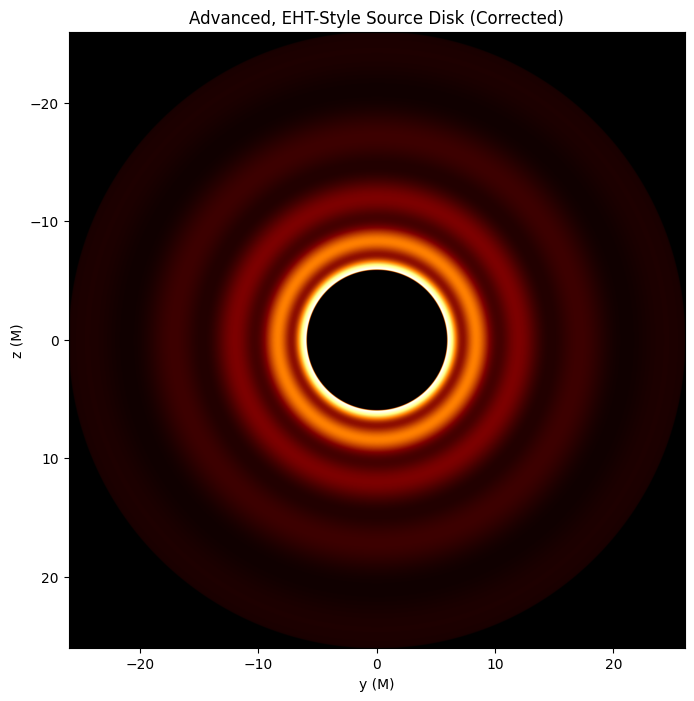


Variable 'advanced_disk_data' created and is ready for use in rendering cells.


In [88]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In Cell 9.B.2: Generate Advanced Disk Texture

print("--- Generating Procedural Texture for the Accretion Disk ---")

advanced_disk_data = generate_advanced_disk_array(
    pixel_width=1024,
    disk_physical_width=p_source_physical_width, # CORRECTED: Uses the master width
    colormap=p_colormap,
    # ... (rest of the parameters are the same) ...
    disk_inner_radius=p_disk_inner_radius,
    disk_outer_radius=p_disk_outer_radius,
    disk_temp_power_law=p_disk_temp_power_law,
    ring_num=p_ring_num,
    ring_contrast=p_ring_contrast,
    ring_log_spacing=p_ring_log_spacing,
    doppler_factor=p_doppler_factor,
    doppler_power=p_doppler_power,
    hotspot_num=p_hotspot_num,
    shape_num_lobes=p_shape_num_lobes,
    shape_inner_amplitude=p_shape_inner_amplitude,
    shape_outer_amplitude=p_shape_outer_amplitude,
    display_image=True
)

print("\nVariable 'advanced_disk_data' created and is ready for use in rendering cells.")

# Standard Static Image Generation

--- Generating a Standard Static Lensed Image ---
--- Generating Static Lensed Image: 'Generated_nrpy_images/static_lensed_disk.png' ---
--- Static image saved to 'Generated_nrpy_images/static_lensed_disk.png' ---

Displaying static image: 'Generated_nrpy_images/static_lensed_disk.png'


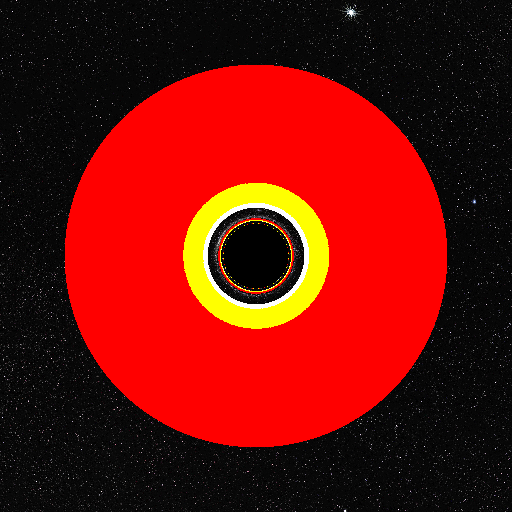

In [89]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In Cell 9.B.3: Standard Static Image Generation

from IPython.display import display, Image as IPImage
import os

print("--- Generating a Standard Static Lensed Image ---")

p_output_filename = os.path.join(p_output_basedir, "static_lensed_disk.png")

#source_image= "rainbow.png"
source_image = advanced_disk_data
# --- Function Call ---
generate_static_lensed_image(
    output_filename=p_output_filename,
    output_pixel_width=p_static_image_pixel_width,
    source_image_width=p_source_physical_width,
    sphere_image=p_sphere_texture_file,
    source_image=source_image,
    
    M_scale=p_mass_of_black_hole,
    blueprint_filename=p_blueprint_filename,
    window_width=p_window_width
)

# --- Display the result ---
if os.path.exists(p_output_filename):
    print(f"\nDisplaying static image: '{p_output_filename}'")
    display(IPImage(filename=p_output_filename))

# Generate Frames for Spinning Disk Animation

In [ ]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In Cell 9.B.4: Generate Frames for Spinning Disk Animation

# Call the function to generate the frames using parameters from the master config cell
generate_animation_frames(
    blueprint_filename=p_blueprint_filename,
    output_folder=p_anim_spinning_folder,
    source_texture=source_image,
    sphere_texture=p_sphere_texture_file,
    source_physical_width=p_disk_physical_width,
    mass_of_black_hole=p_mass_of_black_hole,
    is_prograde=p_anim_spinning_is_prograde,
    num_frames=p_anim_spinning_num_frames,
    orbits_at_isco=p_anim_spinning_orbits_at_isco,
    output_pixel_width=p_animation_pixel_width,
    window_width=p_window_width
)

# Generate Frames for Moving Camera Animation


In [ ]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In Cell 9.B.5: Generate Frames for Moving Camera Animation

import numpy as np
import os

print("--- Generating Frames for a Moving Camera Animation ---")

# --- Camera Path Definition ---
num_camera_frames = 60
camera_path_radius = 40.0
camera_y_pos = 10.0

# --- Main Loop ---
for i in range(num_camera_frames):
    angle = (i / num_camera_frames) * 2 * np.pi
    cam_x = camera_path_radius * np.cos(angle)
    cam_z = camera_path_radius * np.sin(angle)
    
    print(f"\n--- Processing Frame {i+1}/{num_camera_frames}: Camera at (x={cam_x:.2f}, y={camera_y_pos:.2f}, z={cam_z:.2f}) ---")
    
    # Create a temporary parameter file for this specific frame
    temp_par_content = f"camera_pos_x = {cam_x:.3f}\ncamera_pos_y = {camera_y_pos:.3f}\ncamera_pos_z = {cam_z:.3f}\n"
    temp_par_content += f"M_scale = {p_mass_of_black_hole}\na_spin = 0.99\nscan_density = 256\n" # Lower density for speed
    temp_par_filename = os.path.join("project/photon_geodesic_integrator", "temp_camera_anim.par")
    with open(temp_par_filename, "w") as f:
        f.write(temp_par_content)

    # Run C code to generate a new blueprint
    blueprint_frame_name = f"blueprint_cam_frame_{i:04d}.bin"
    run_integrator_and_rename_blueprint(
        project_dir="project/photon_geodesic_integrator",
        executable_name="photon_geodesic_integrator",
        args_string="temp_camera_anim.par",
        output_blueprint_name=blueprint_frame_name,
        bin_folder=p_anim_camera_blueprint_folder
    )
    
    # Render the image for this frame
    blueprint_path = os.path.join("project/photon_geodesic_integrator", p_anim_camera_blueprint_folder, blueprint_frame_name)
    if not os.path.exists(blueprint_path):
        print(f"ERROR: Blueprint '{blueprint_path}' not found. Skipping rendering.")
        continue
        
    image_frame_name = os.path.join(p_anim_camera_frames_folder, f"frame_{i:04d}.png")
    
    # Use the static image generator, as the disk is not spinning in this animation
    generate_static_lensed_image(
        output_filename=image_frame_name,
        output_pixel_width=p_animation_pixel_width,
        source_image_width=p_disk_physical_width,
        sphere_image=p_sphere_texture_file,
        source_image=advanced_disk_data,
        M_scale=p_mass_of_black_hole,
        blueprint_filename=blueprint_path,
        window_width=p_window_width
    )

print("\n--- All frames for moving camera animation generated. ---")

# Final Video Encoding

In [ ]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In Cell 9.B.6: Final Video Encoding

# --- Choose which animation to encode ---

# Option 1: Spinning Disk
p_input_frames_folder = p_anim_spinning_folder
p_output_video_file = p_anim_spinning_video_file

# Option 2: Moving Camera (uncomment to use)
# p_input_frames_folder = p_anim_camera_frames_folder
# p_output_video_file = p_anim_camera_video_file

# --- Encoding settings ---
p_frame_rate = 30
p_quality_factor = 18

# --- Function Call ---
encode_video_from_frames(
    image_folder=p_input_frames_folder,
    output_video_path=p_output_video_file,
    frame_rate=p_frame_rate,
    crf=p_quality_factor
)